In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

Periode  thuis opladen  elektrische auto  hybride elektrisch  \
0  2007-07-01              0                 1                   0   
1  2007-08-01              0                 1                   0   
2  2007-09-01              0                 1                   0   

   Bijtelling (%)  Consumentenvertrouwen  Economisch klimaat  Koopbereidheid  \
0              22                   14.0                22.0             9.0   
1              22                   12.0                17.0             9.0   
2              22                   10.0                12.0             9.0   

   Grote aankopen  BenzineEuro95_1_first  ...  TVV_Lag1  TVV_Lag2  TVV_Lag3  \
0             6.2                  1.451  ...     112.0      84.0      62.0   
1             5.6                  1.415  ...     124.0     112.0      84.0   
2             5.0                  1.422  ...      96.0     124.0     112.0   

   TVV_Lag4  TVV_Lag5  TVV_Lag6  year  month  quarter  \
0     123.0      39.0      31.0  2007      7        3   
1      62.0     123.0      39.0  2007      8        3   
2      84.0      62.0     123.0  2007      9        3   

   Totaal_verkochte_wegvoertuigen  
0                             124  
1                              96  
2                             120  

[3 rows x 29 columns]

# Baseline

## Lag only

### Linear regreasion

              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  1768.242189  4560.187794  0.749676  0.311196
1    Keywords + Lag  1783.524002  4394.640157  0.767521  0.300019
2  Bijtelling + Lag  1777.358475  4566.919852  0.748937  0.324832
3  Confidence + Lag  1825.650637  4545.353729  0.751302  0.342044
4        Fuel + Lag  1827.083999  4599.390937  0.745354  0.371130
5      All Features  1973.549904  4480.215320  0.758379  0.618318


<Figure size 1200x600 with 0 Axes>

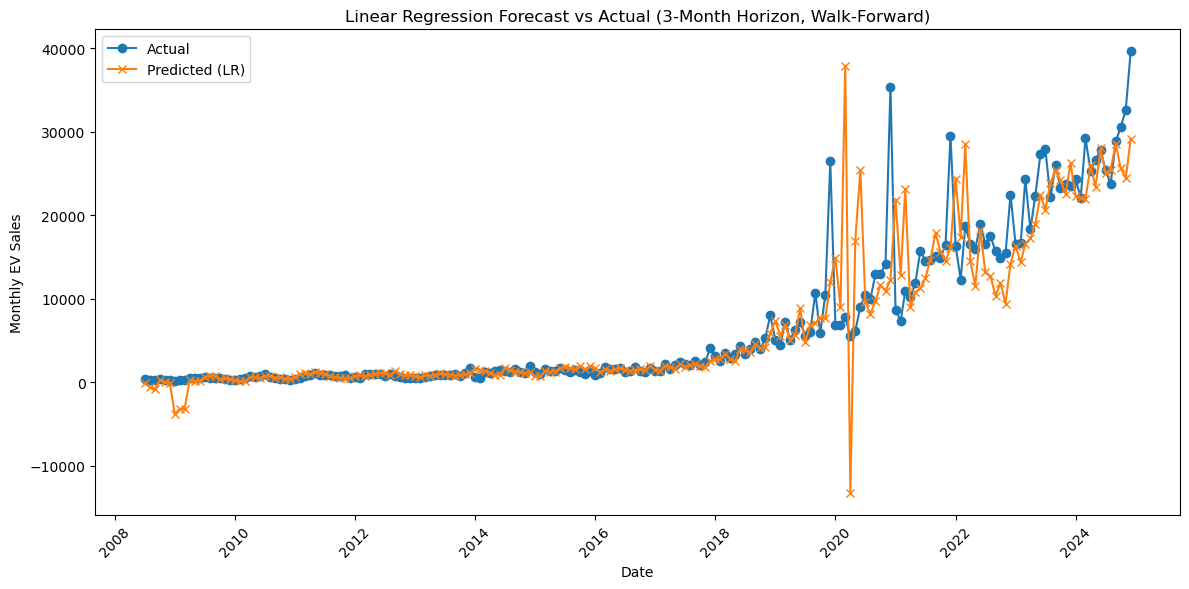

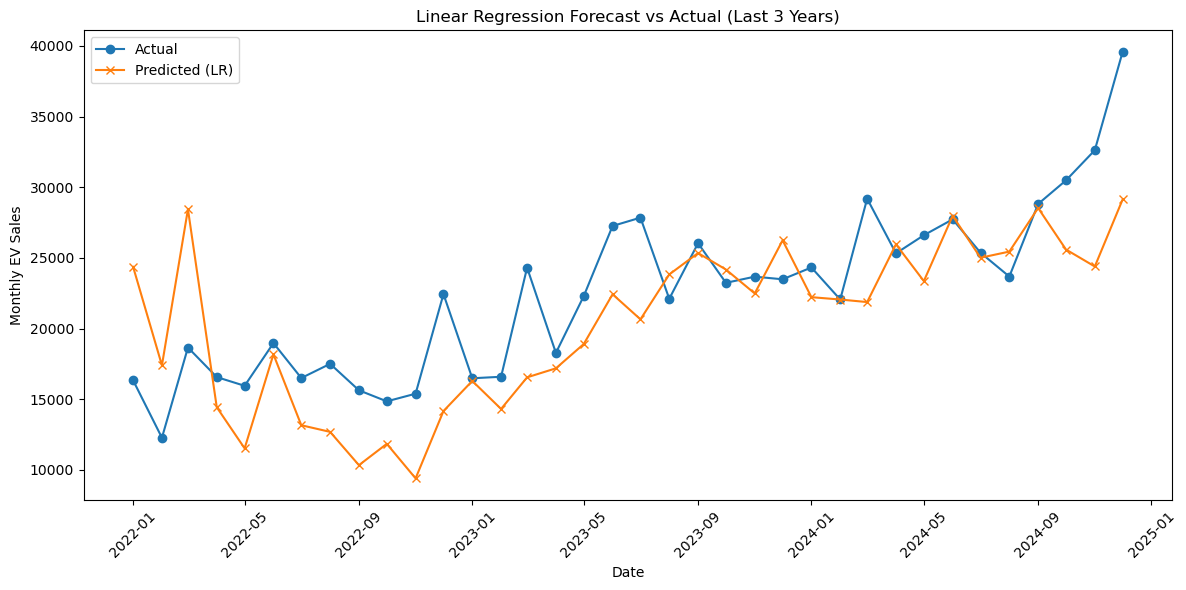

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Simulate the feature_sets dictionary
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

feature_sets = {
    ' (Lag Only)': lagged_features,
    'Keywords + Lag': lagged_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lagged_features + ['Bijtelling (%)'],
    'Confidence + Lag': lagged_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lagged_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lagged_features

feature_sets['All Features'] = all_features

# Load df_lagged
target_col = 'Totaal_verkochte_wegvoertuigen'

# Config
forecast_horizon = 3
initial_train_size = 12
step_size = 3

# Evaluate Linear Regression for each feature set
results = []

for name, features in feature_sets.items():
    X = df_lagged[features].
    
    ues
    y = df_lagged[target_col].values
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) 

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
n_windows = (len(df_lagged) - initial_train_size - forecast_horizon + 1) // step_size + 1
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

# Convert list to datetime-indexed Series for plotting
plot_index = pd.to_datetime(test_periods)

# Plot with datetime on x-axis
plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Linear Regression (3-month horizon, Lagged Features Only):
MAE: 2129.99
RMSE: 5040.45
R²: 0.7180
MAPE: 29.16%


<Figure size 1200x600 with 0 Axes>

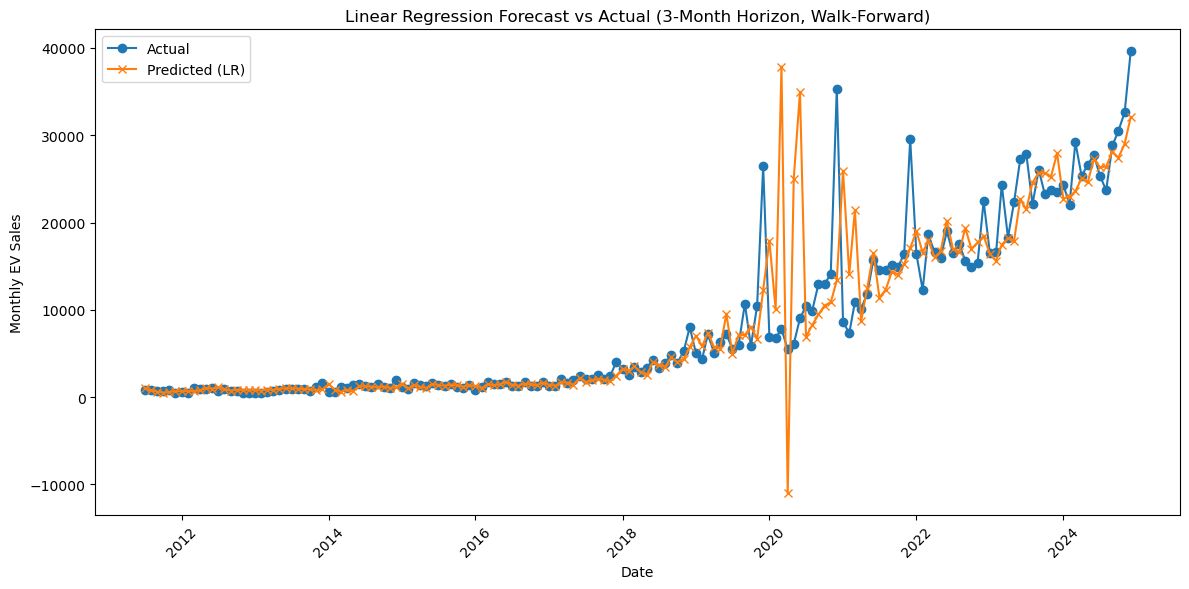

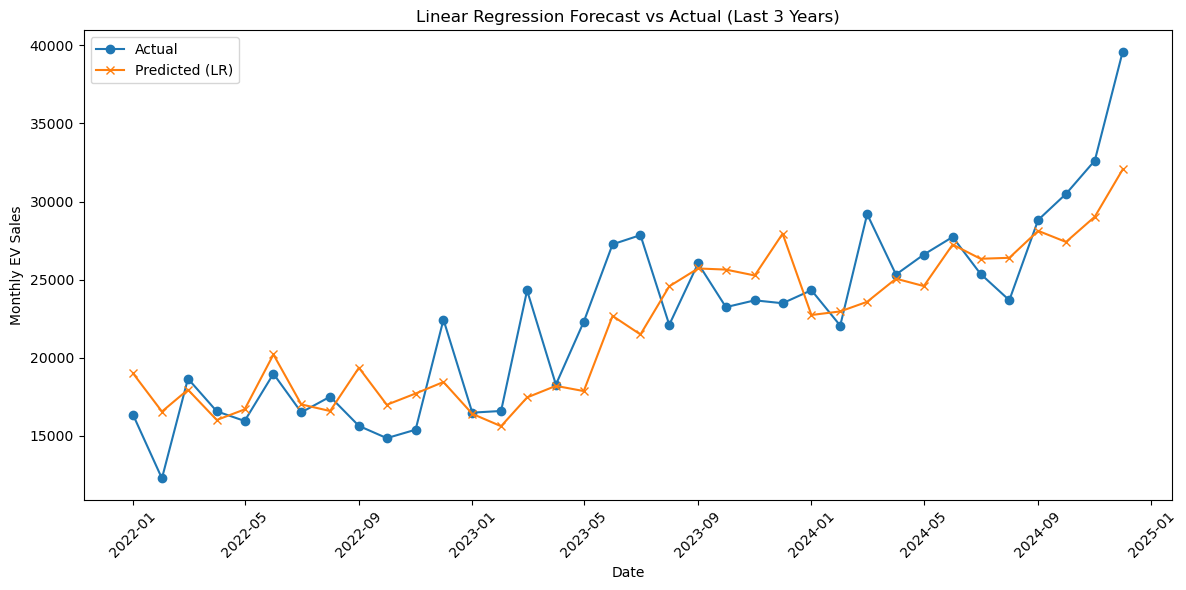

In [5]:
from sklearn.linear_model import LinearRegression


lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lagged_features

selected_feature_sets = {
    '(Lag Only)': lagged_features,
    'All Features': all_features
}

# Configuratie
forecast_horizon = 3
initial_train_size = 48
step_size = 3
alpha = 1.0
l1_ratio = 0.5
target_col = 'Totaal_verkochte_wegvoertuigen'
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']


X = df_lagged[lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print("Linear Regression (3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
n_windows = (len(df_lagged) - initial_train_size - forecast_horizon + 1) // step_size + 1
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

# Convert list to datetime-indexed Series for plotting
plot_index = pd.to_datetime(test_periods)

# Plot with datetime on x-axis
plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()




### Arimax

ARIMAX (3-month horizon, Lagged Features Only):
MAE: 3679.85
RMSE: 4858.76
R²: 0.3531
MAPE: 0.17


<Figure size 1200x600 with 0 Axes>

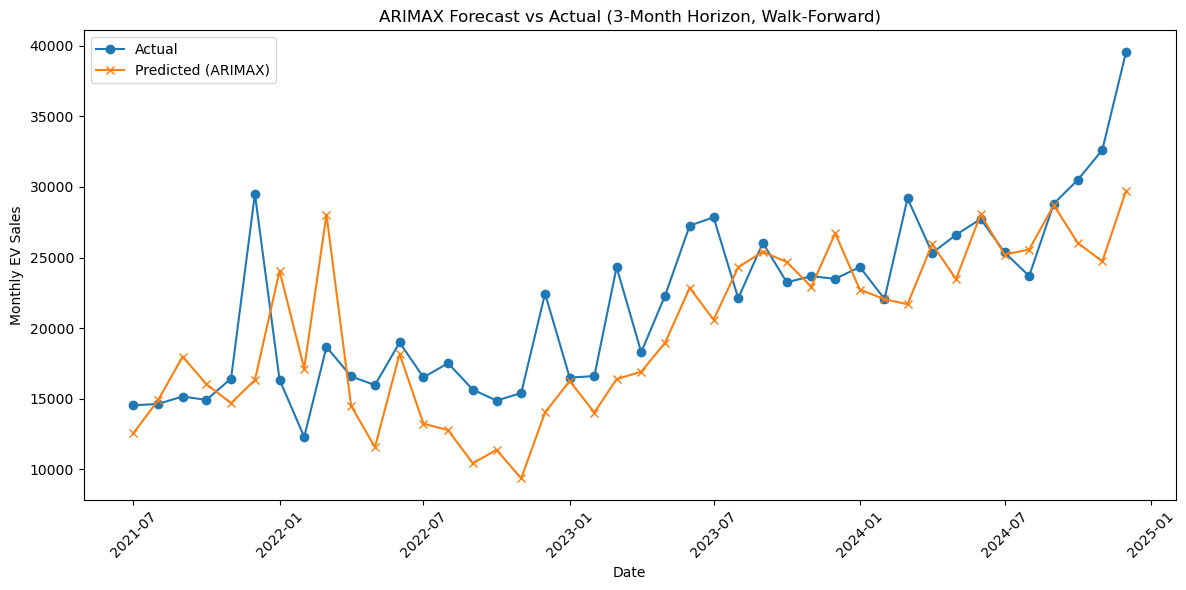

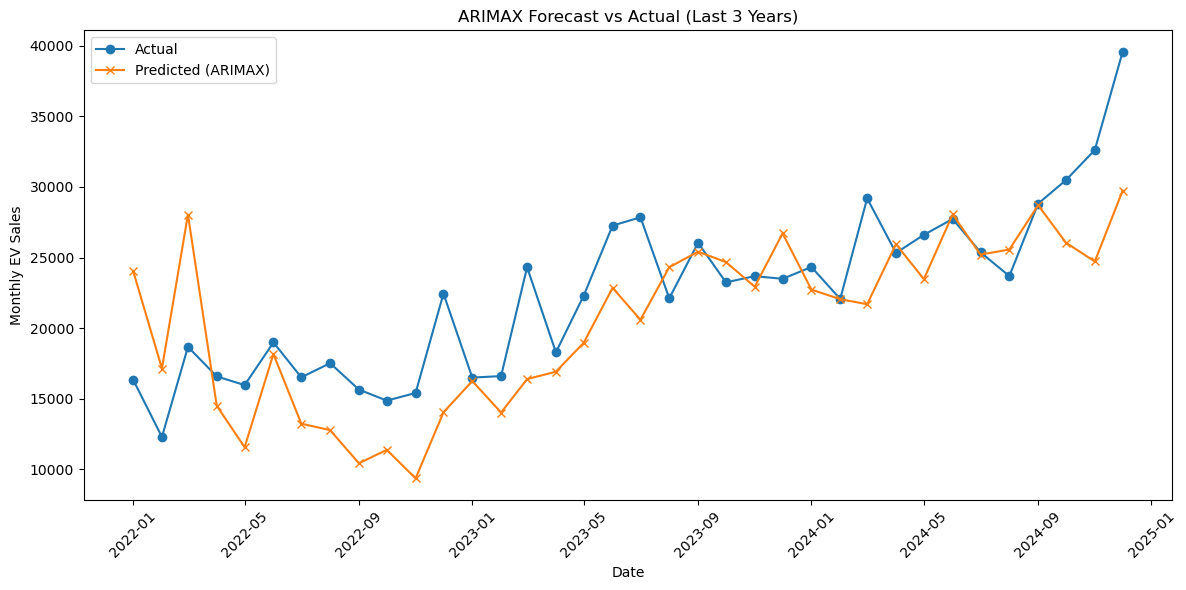

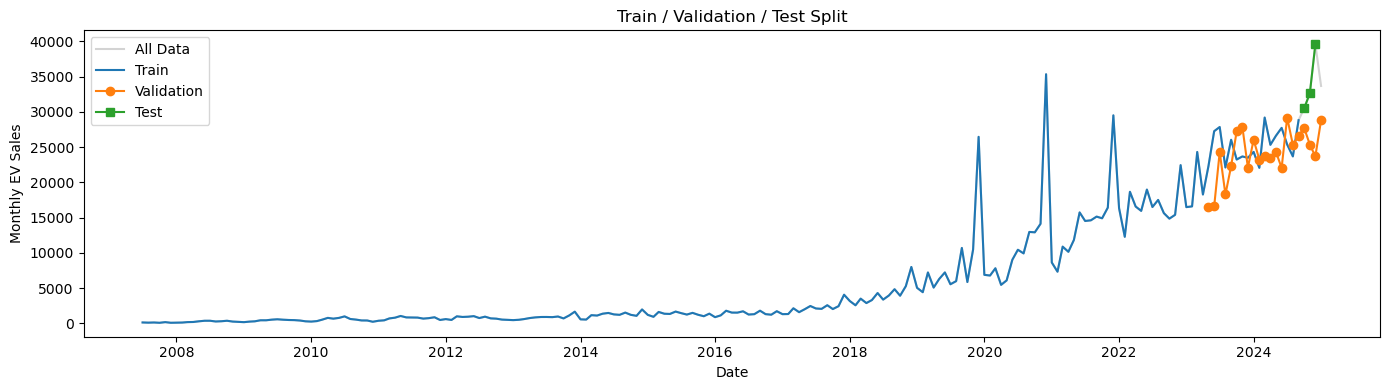

In [ ]:
# Use ARIMAX (SARIMAX with exogenous variables)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    # Fit SARIMAX (ARIMAX) model
    model = SARIMAX(y_train, exog=X_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+forecast_horizon-1, exog=X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) 

print("ARIMAX (3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate test periods for plotting
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize the train/validation/test split
plt.figure(figsize=(14, 4))
plt.plot(df_lagged['Periode'], df_lagged[target_col], label='All Data', color='lightgray')
plt.plot(train['Periode'], train[target_col], label='Train', color='tab:blue')
plt.plot(val_dates, y_val, label='Validation', color='tab:orange', marker='o')
plt.plot(test['Periode'], test[target_col], label='Test', color='tab:green', marker='s')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.title('Train / Validation / Test Split')
plt.legend()r
plt.tight_layout()
plt.show()


### XGBOOST

XGBoost (3-month horizon, Lagged Features Only):
MAE: 1897.60
RMSE: 3831.40
R²: 0.8370
MAPE: 0.23


<Figure size 1200x600 with 0 Axes>

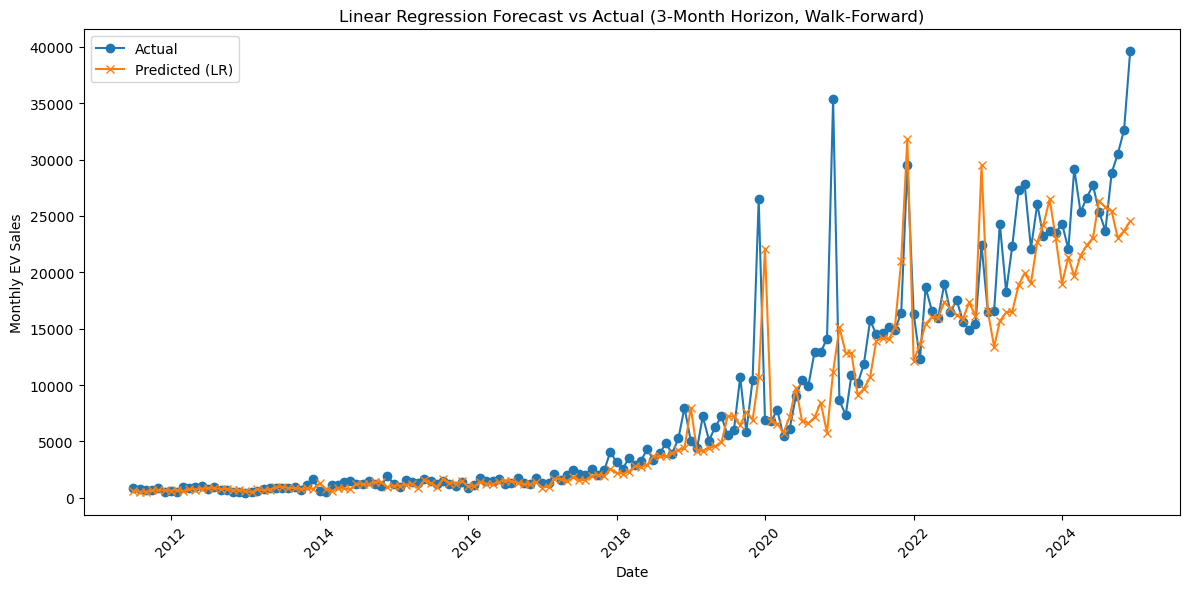

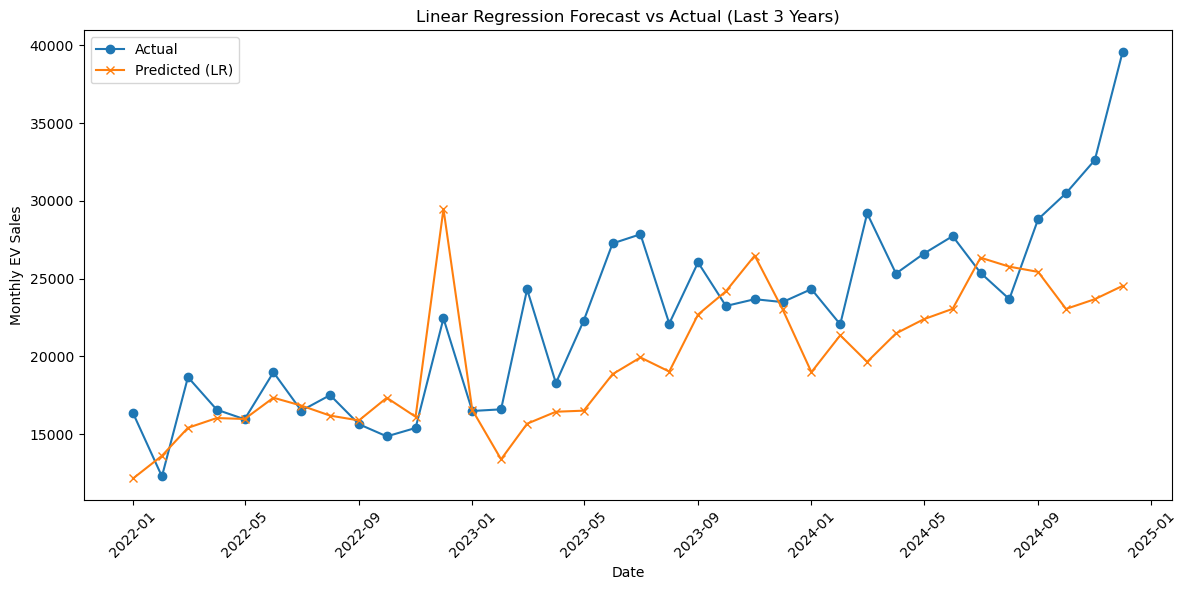

In [64]:
# Use XGBoost 
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) 

print("XGBoost (3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
n_windows = (len(df_lagged) - initial_train_size - forecast_horizon + 1) // step_size + 1
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

# Convert list to datetime-indexed Series for plotting
plot_index = pd.to_datetime(test_periods)

# Plot with datetime on x-axis
plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR)', marker='x')
plt.title('Linear Regression Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  1558.334717  3119.519194  0.891970  0.205734
1    Keywords + Lag  1607.672974  3184.212776  0.887442  0.206596
2  Bijtelling + Lag  1561.564941  3126.087171  0.891514  0.205337
3  Confidence + Lag  1584.172974  3072.782290  0.895182  0.212386
4        Fuel + Lag  1506.914185  3174.303546  0.888142  0.212355
5      All Features  1876.159668  3942.283856  0.827469  0.239717


<Figure size 1200x600 with 0 Axes>

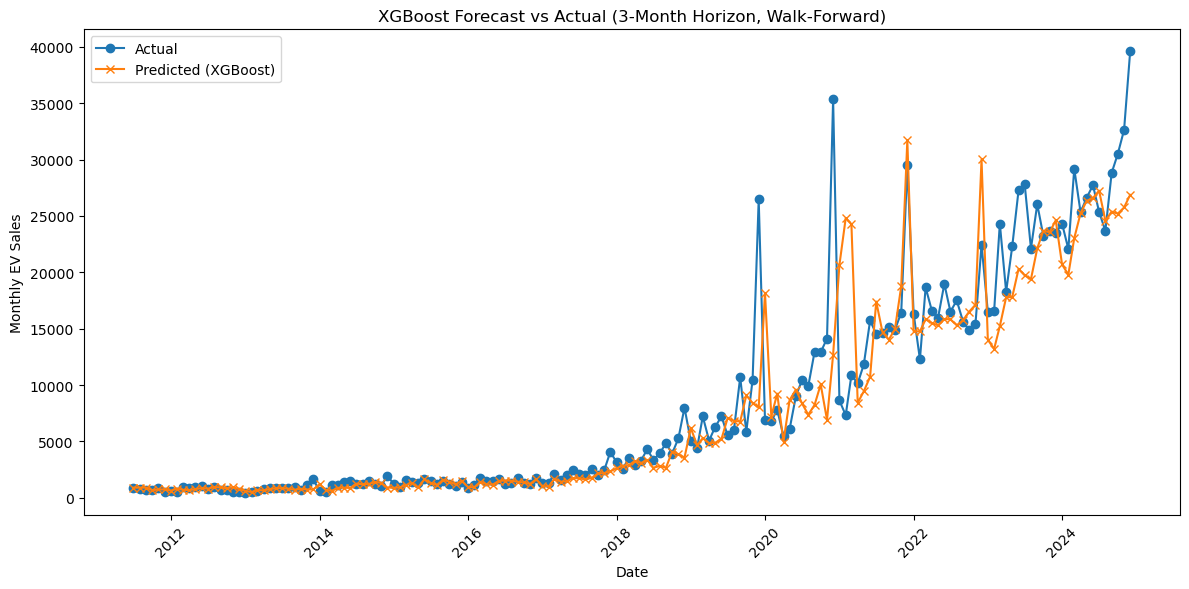

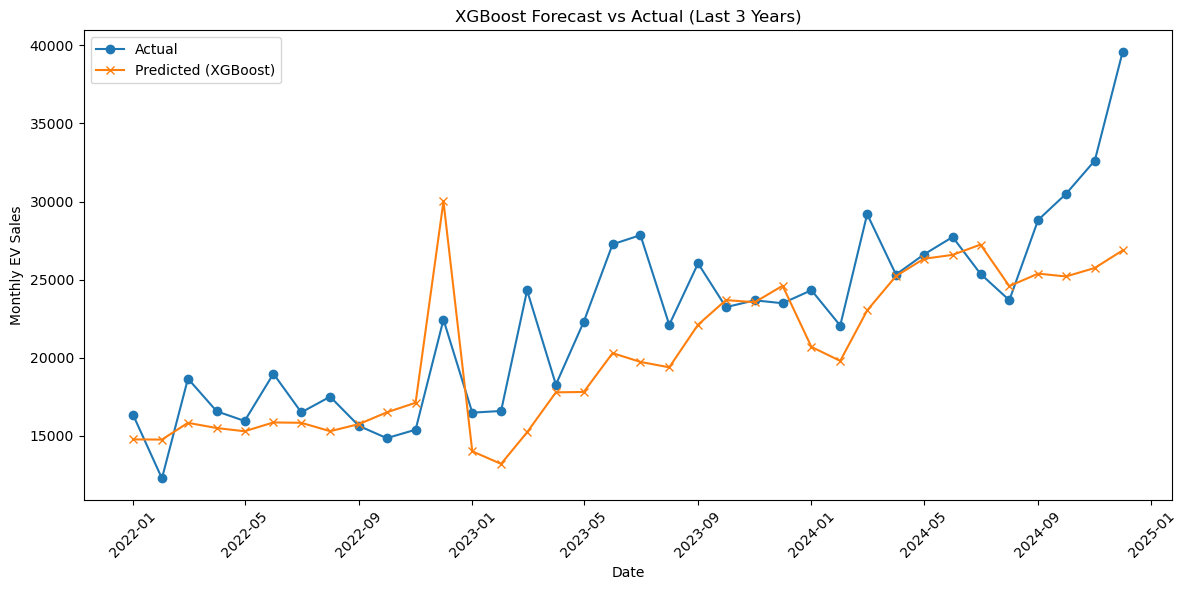

In [68]:
import xgboost as xgb

results = []

for name, features in feature_sets.items():
    X = df_lagged[features].values
    y = df_lagged[target_col].values
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]

        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, #200 
        learning_rate=0.1,
        max_depth=3,#5
        random_state=42,
        eval_metric="rmse")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) 

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


ARIMAX

ARIMAX (3-month horizon, Lagged Features Only):
MAE: 2301.90
RMSE: 5006.99
R²: 0.7217
MAPE: 0.31


<Figure size 1200x600 with 0 Axes>

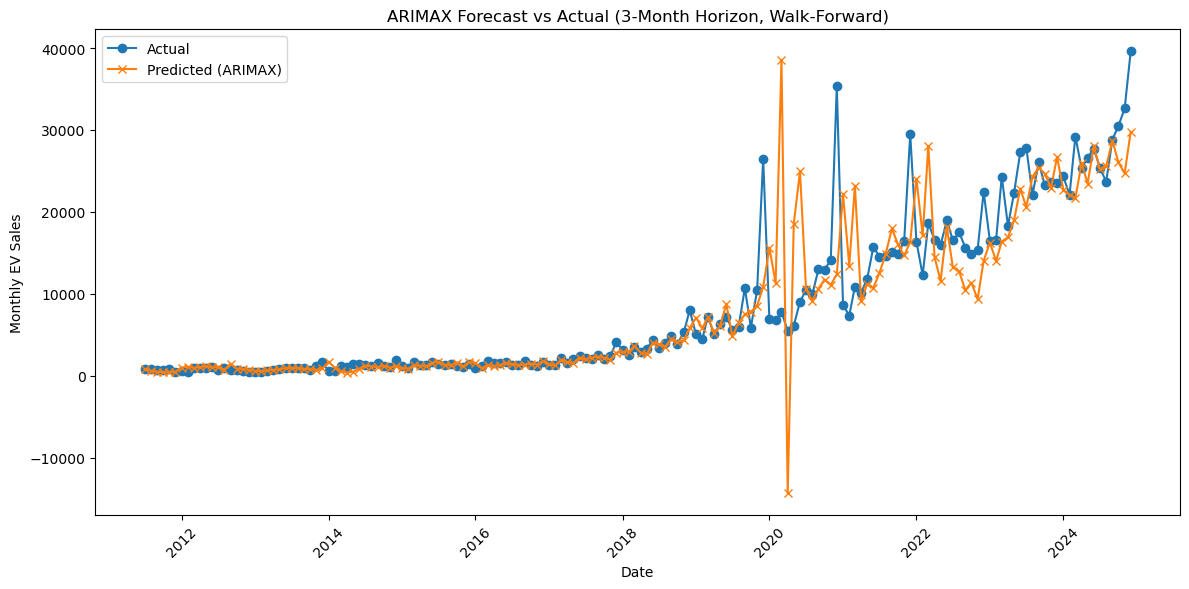

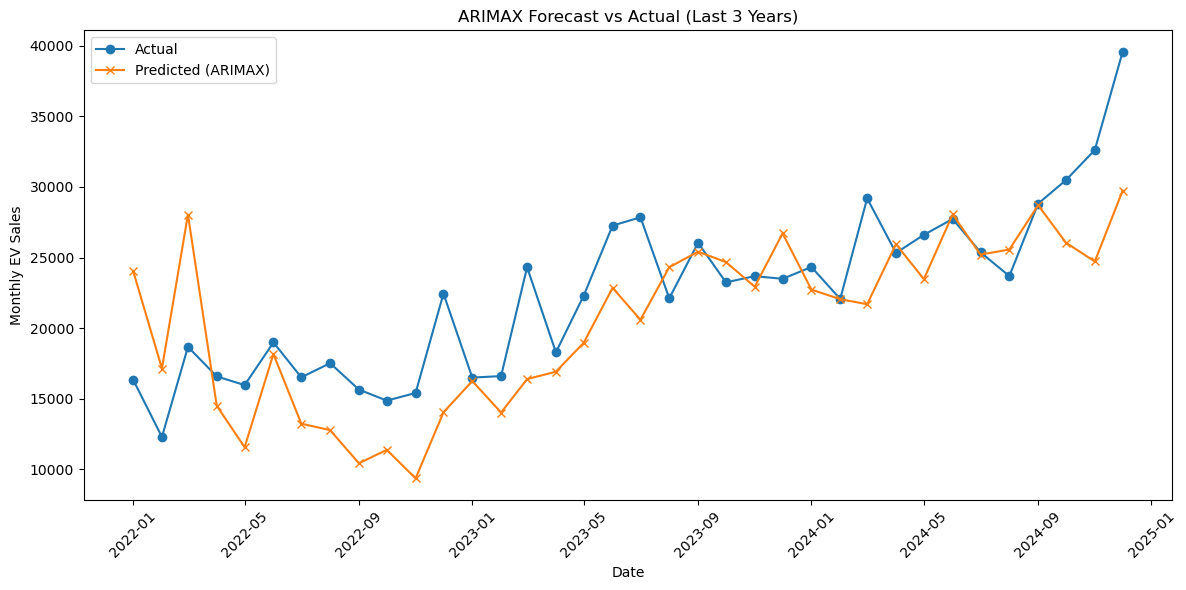

In [8]:
# Use ARIMAX (SARIMAX with exogenous variables)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    # Fit SARIMAX (ARIMAX) model
    model = SARIMAX(y_train, exog=X_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+forecast_horizon-1, exog=X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) 

print("ARIMAX (3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate test periods for plotting
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


test van 70%

In [73]:
def walk_forward_validation_multi(df, features, target_col, forecast_horizon=3):
    """
    Walk-forward validation with multi-step (horizon) forecasting using XGBoost.
    Uses recursive prediction for lagged features.
    Returns MAE, RMSE, R2, and MAPE for all forecasted steps.
    """
    X = df[features].values
    y = df[target_col].values
    lagged_features = features[:6]  # Assumes first 6 are lagged
    other_features = [f for f in features if f not in lagged_features]
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse")
        model.fit(X_train, y_train)
        y_temp = list(y[:i])  # Start with actuals up to now
        for j in range(forecast_horizon):
            lags = y_temp[-6:]  # Use last 6 values as lags
            other_feats = df[other_features].iloc[i + j].values
            X_test = np.concatenate([lags, other_feats]).reshape(1, -1)
            y_pred = model.predict(X_test)[0]
            y_temp.append(y_pred)
            predictions.append(y_pred)
            actuals.append(y[i + j])
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Example usage for all feature sets:
results = []
for label, features in selected_feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation_multi(train, features, target_col, forecast_horizon=3)
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df = pd.DataFrame(results)
print(results_df)


          Model          MAE         RMSE        R²   MAPE (%)
0    (Lag Only)  2759.186279  3501.245921  0.530453  13.987534
1  All Features  2988.264404  3896.894918  0.418338  14.412709


              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  2074.812368  4980.312889  0.724650  0.280679
1    Keywords + Lag  2104.791238  4851.265700  0.738735  0.281167
2  Bijtelling + Lag  2065.128123  4948.730410  0.728132  0.276672
3  Confidence + Lag  2214.848243  5068.575209  0.714804  0.296617
4        Fuel + Lag  2139.429383  5011.100357  0.721236  0.290354
5      All Features  2301.897926  5006.988053  0.721693  0.310147


<Figure size 1200x600 with 0 Axes>

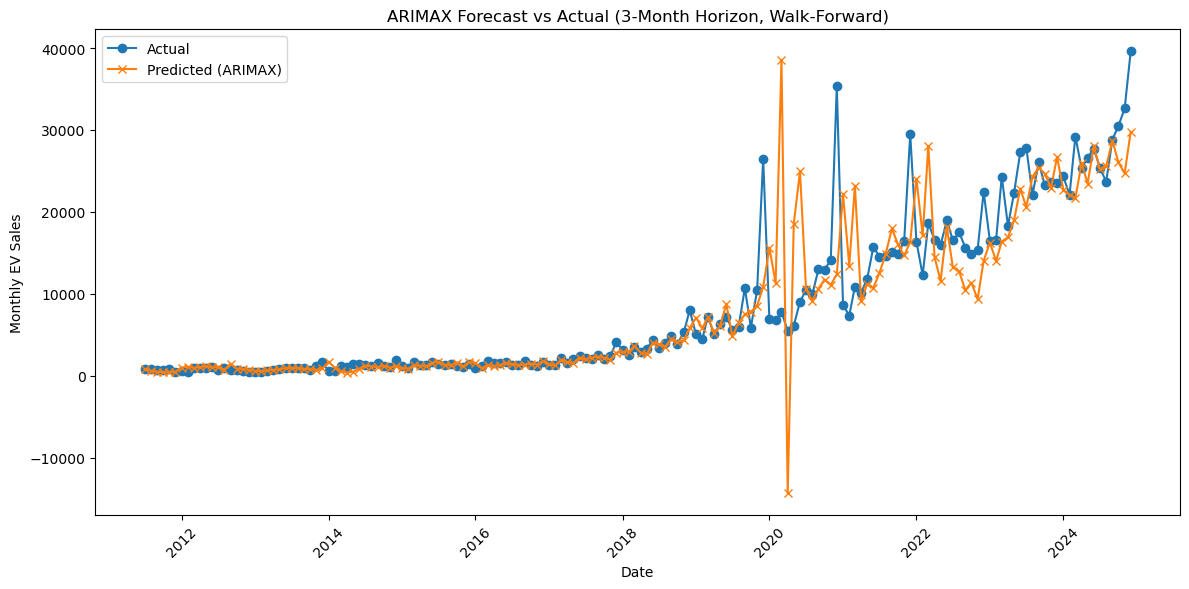

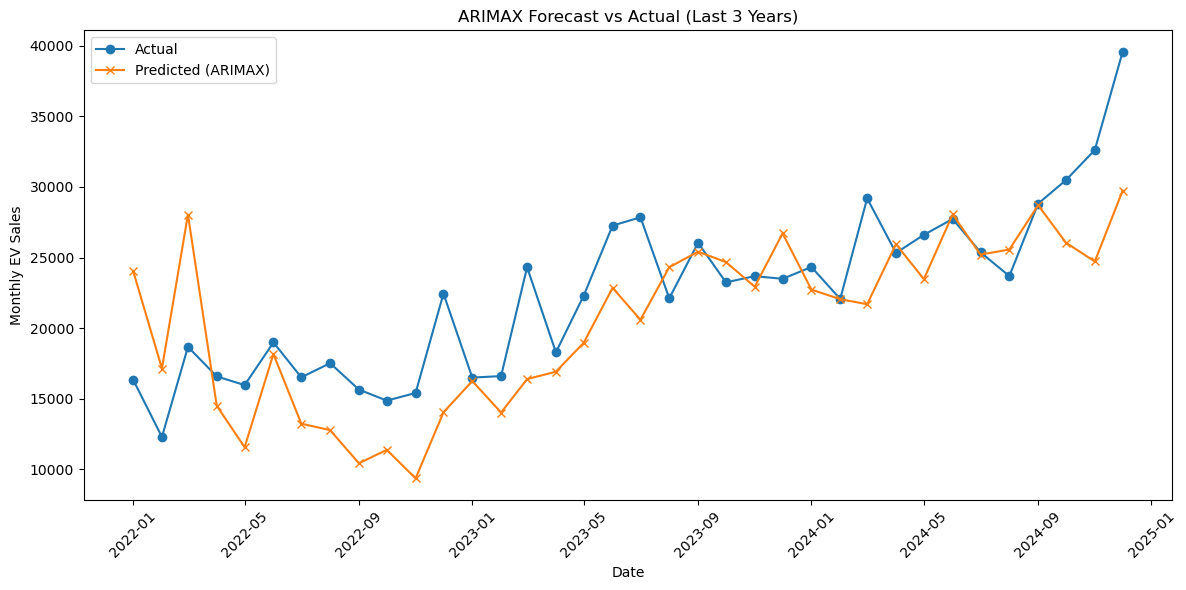

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Evaluate ARIMAX for each feature set
results = []

for name, features in feature_sets.items():
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        train = df_lagged.iloc[:i]
        test = df_lagged.iloc[i:i + forecast_horizon]

        y_train = train[target_col].values
        y_test = test[target_col].values
        exog_train = train[features].values
        exog_test = test[features].values

        # ARIMAX: order can be tuned; here (1,0,0) as a simple example
        try:
            model = sm.tsa.SARIMAX(y_train, exog=exog_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
        except Exception:
            # fallback to mean if ARIMAX fails
            y_pred = np.full(forecast_horizon, np.mean(y_train))

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals))

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# All features:

### Linear

Linear Regression (3-month horizon, All Features):
MAE: 2289.91
RMSE: 4925.07
R²: 0.7307
MAPE: 0.31


<Figure size 1200x600 with 0 Axes>

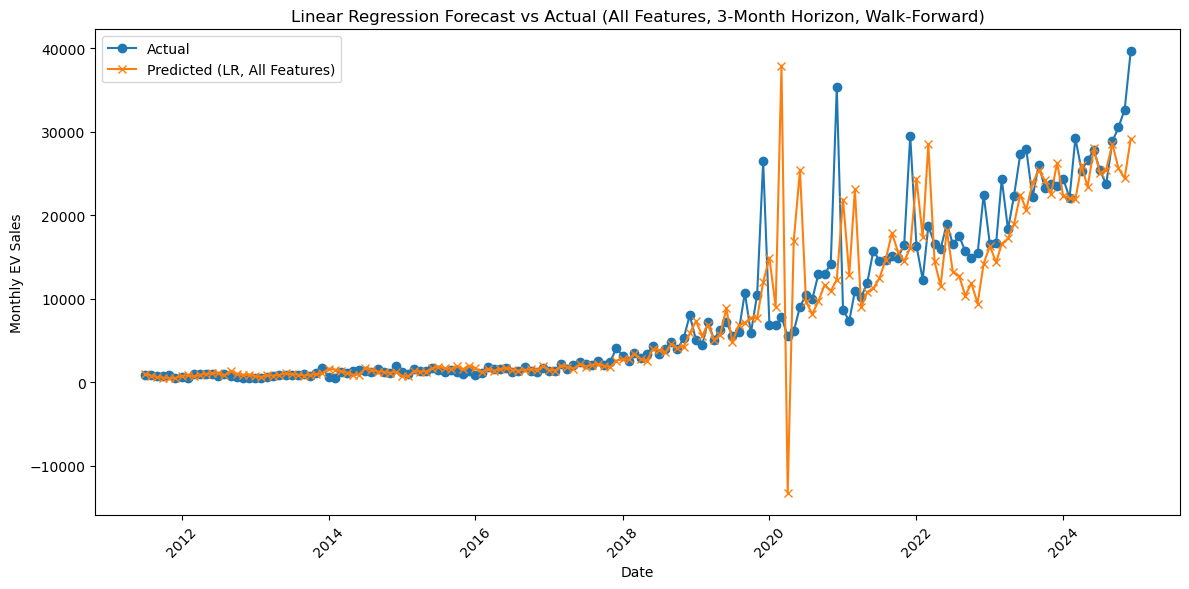

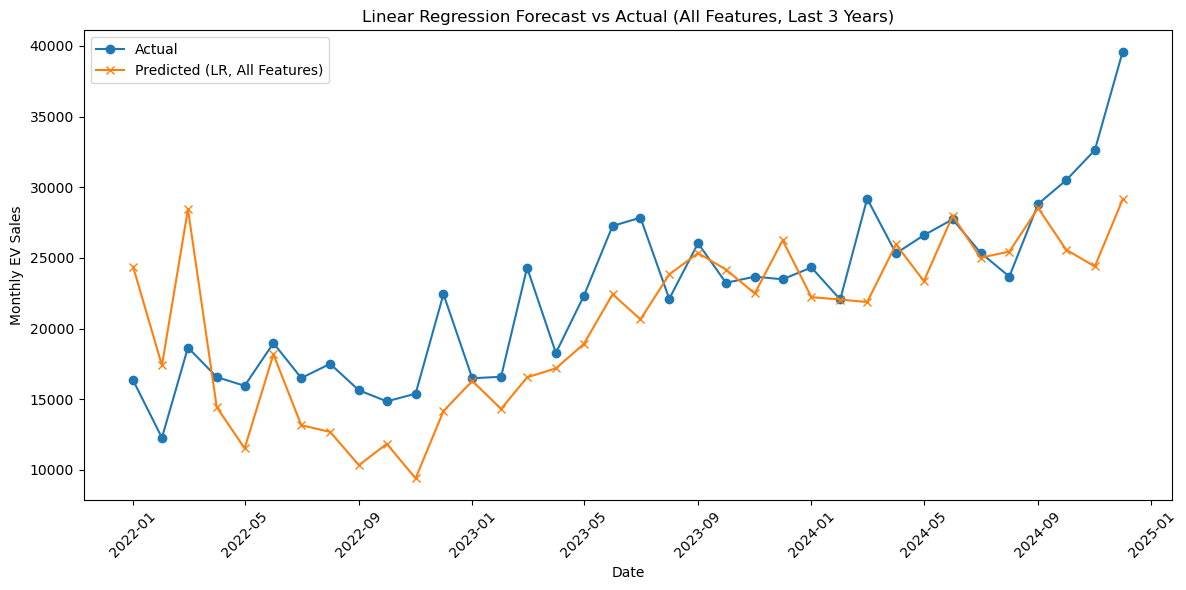

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [10]:
from sklearn.linear_model import LinearRegression

# Use all features for X
X = df_lagged[all_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) 

print("Linear Regression (3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")



# Plotting
plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR, All Features)', marker='x')
plt.title('Linear Regression Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR, All Features)', marker='x')
plt.title('Linear Regression Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


print 

### XGboost

XGBoost (3-month horizon, All Features):
MAE: 2083.55
RMSE: 4030.84
R²: 0.8196
MAPE: 0.26


<Figure size 1200x600 with 0 Axes>

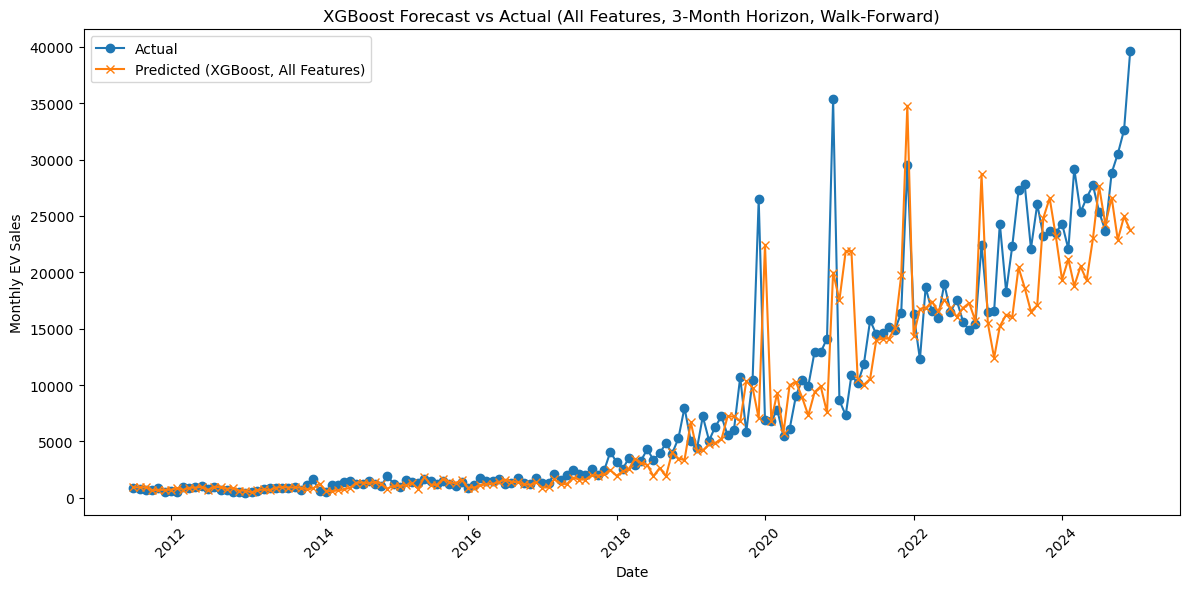

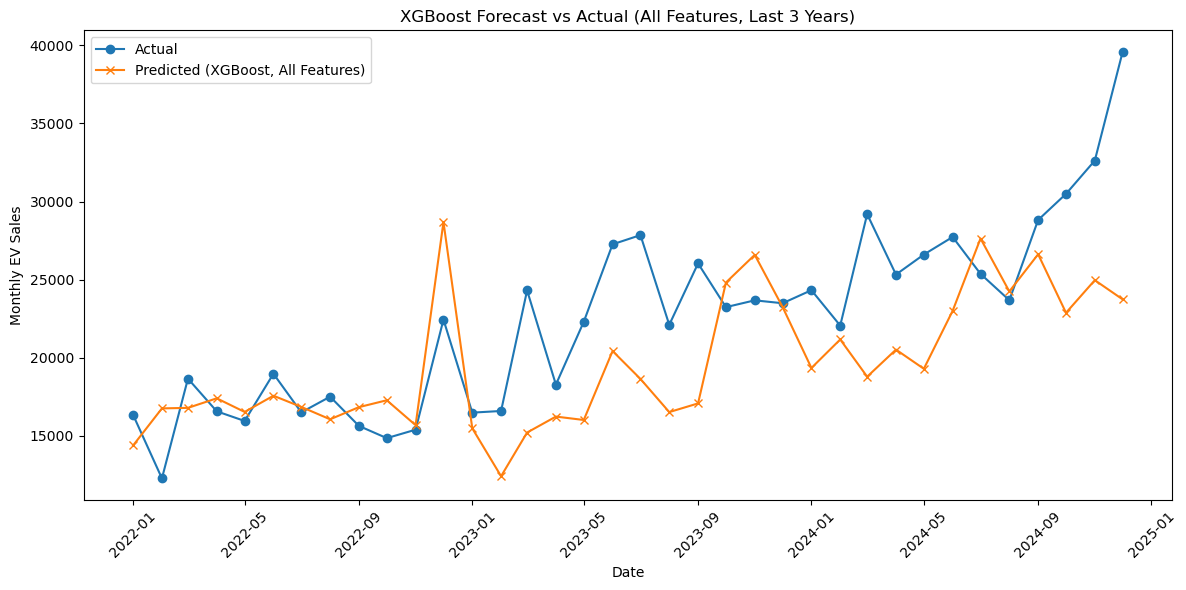

In [11]:
# Use XGBoost instead of Linear Regression
# X, y, all_features, initial_train_size, forecast_horizon, step_size, and target_col are already defined

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, All Features)', marker='x')
plt.title('XGBoost Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost, All Features)', marker='x')
plt.title('XGBoost Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Arimax

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Use ARIMAX (SARIMAX with exogenous variables) instead of XGBoost
# Use all features for X and y
X = df_lagged[all_features].values
y = df_lagged[target_col].values


# Split last 10% of test set as validation
n_total = len(df_lagged)
n_val = int(0.1 * n_total)
X_train, X_val = X[:-n_val], X[-n_val:]
y_train, y_val = y[:-n_val], y[-n_val:]

def arimax_val_rmse(order_p, order_d, order_q):
    order = (int(order_p), int(order_d), int(order_q))
    try:
        model = SARIMAX(y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_val_pred = model_fit.forecast(steps=len(y_val), exog=X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        return -rmse  # negative for maximization
    except Exception:
        return -1e10  # penalize failed runs

pbounds = {
    'order_p': (0, 3),
    'order_d': (0, 2),
    'order_q': (0, 3)
}

optimizer = BayesianOptimization(
    f=arimax_val_rmse,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=10)

best_params = optimizer.max['params']
best_order = (int(best_params['order_p']), int(best_params['order_d']), int(best_params['order_q']))
print("Best ARIMAX order found on validation set:", best_order)

# Use best_order for walk-forward below
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    y_train = y[:i]
    y_test = y[i:i + forecast_horizon]
    exog_train = X[:i]
    exog_test = X[i:i + forecast_horizon]

    try:
        model = SARIMAX(y_train, exog=exog_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
    except Exception:
        y_pred = np.full(forecast_horizon, np.mean(y_train))

    predictions.extend(y_pred)
    actuals.extend(y_val)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("ARIMAX (3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX, All Features)', marker='x')
plt.title('ARIMAX Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX, All Features)', marker='x')
plt.title('ARIMAX Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


|   iter    |  target   |  order_d  |  order_p  |  order_q  |
-------------------------------------------------------------
| 1         | -3.327e+0 | 0.7491    | 2.852     | 2.196     |
| 2         | -1.46e+04 | 1.197     | 0.4681    | 0.468     |
| 3         | -5.866e+0 | 0.1162    | 2.599     | 1.803     |
| 4         | -9.673e+0 | 1.416     | 0.06175   | 2.91      |
| 5         | -1.46e+04 | 1.665     | 0.637     | 0.5455    |
| 6         | -2.2e+04  | 2.0       | 3.0       | 3.0       |
| 7         | -3.323e+0 | 0.07411   | 3.0       | 2.68      |
| 8         | -5.709e+0 | 0.1675    | 1.906     | 2.877     |
| 9         | -1.046e+0 | 1.095     | 3.0       | 0.753     |
| 10        | -5.245e+0 | 0.009351  | 0.2587    | 2.768     |
| 11        | -3.227e+0 | 0.0       | 1.021     | 1.874     |
| 12        | -5.23e+03 | 0.02127   | 0.01305   | 1.674     |
| 13        | -5.709e+0 | 0.895     | 1.535     | 2.028     |
| 14        | -5.296e+0 | 0.006874  | 1.543     | 0.08859   |
| 15    

ValueError: Found input variables with inconsistent numbers of samples: [1134, 162]

              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  2074.812368  4980.312889  0.724650  0.280679
1    Keywords + Lag  2104.791238  4851.265700  0.738735  0.281167
2  Bijtelling + Lag  2065.128123  4948.730410  0.728132  0.276672
3  Confidence + Lag  2214.848243  5068.575209  0.714804  0.296617
4        Fuel + Lag  2139.429383  5011.100357  0.721236  0.290354
5      All Features  2301.897926  5006.988053  0.721693  0.310147


<Figure size 1200x600 with 0 Axes>

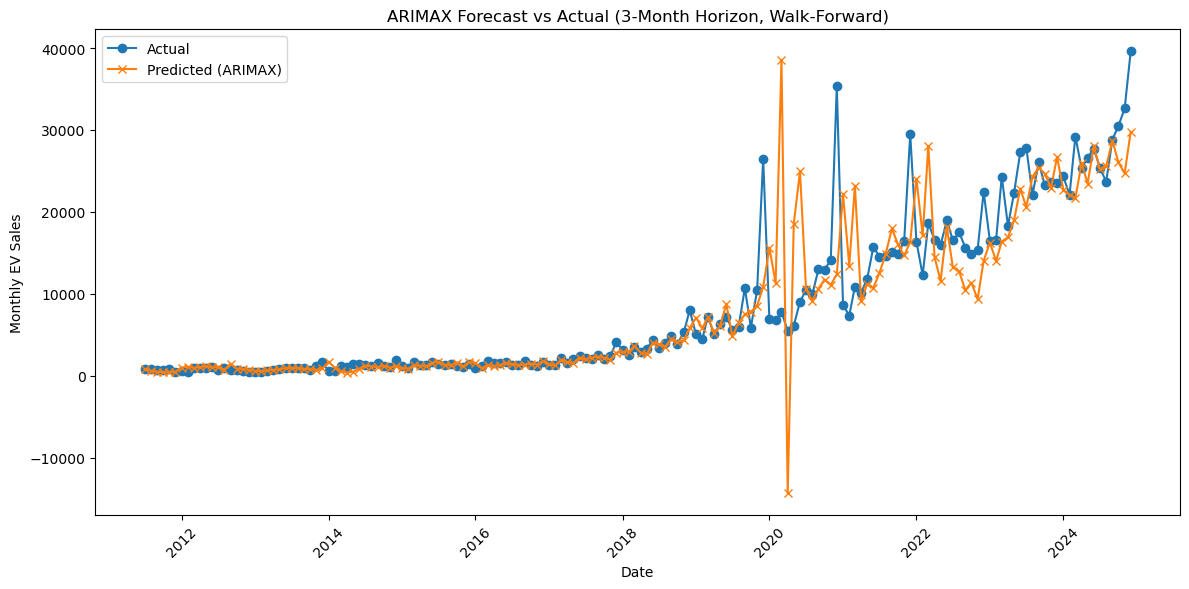

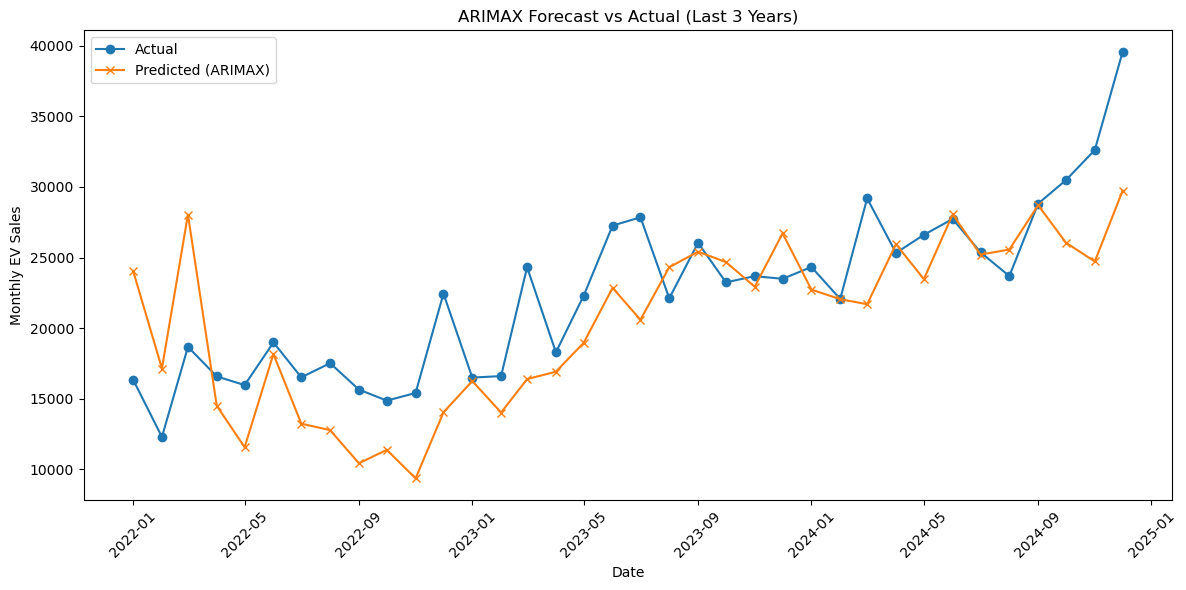

In [13]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Evaluate ARIMAX for each feature set
results = []

for name, features in feature_sets.items():
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        train = df_lagged.iloc[:i]
        test = df_lagged.iloc[i:i + forecast_horizon]

        y_train = train[target_col].values
        y_test = test[target_col].values
        exog_train = train[features].values
        exog_test = test[features].values

        # ARIMAX: order can be tuned; here (1,0,0) as a simple example
        try:
            model = sm.tsa.SARIMAX(y_train, exog=exog_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
        except Exception:
            # fallback to mean if ARIMAX fails
            y_pred = np.full(forecast_horizon, np.mean(y_train))

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals))

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX)', marker='x')
plt.title('ARIMAX Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# hyperparameter tuning lagged only

### XGBoost
with val

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -9.626e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -9.531e+0 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -9.345e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -9.685e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -8.911e+0 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -8.994e+0 | 0.8517    | 0.04534   | 3.475     | 138.1     | 0.7508    |
| 7         | -9.584e+0 | 0.5       | 0.3       | 8.0       | 140.7     | 0.5       |
| 8         | -1.005e+0 | 0.5301    | 0.01951   | 2.054     | 140.4     | 0.7491    |
| 9         | -9.387e+0 | 0.972     | 0.09234   | 4.044     | 141.9     | 0.8203    |
| 10        | -9.186e+0 | 0.7464    | 0.09259   | 3.79

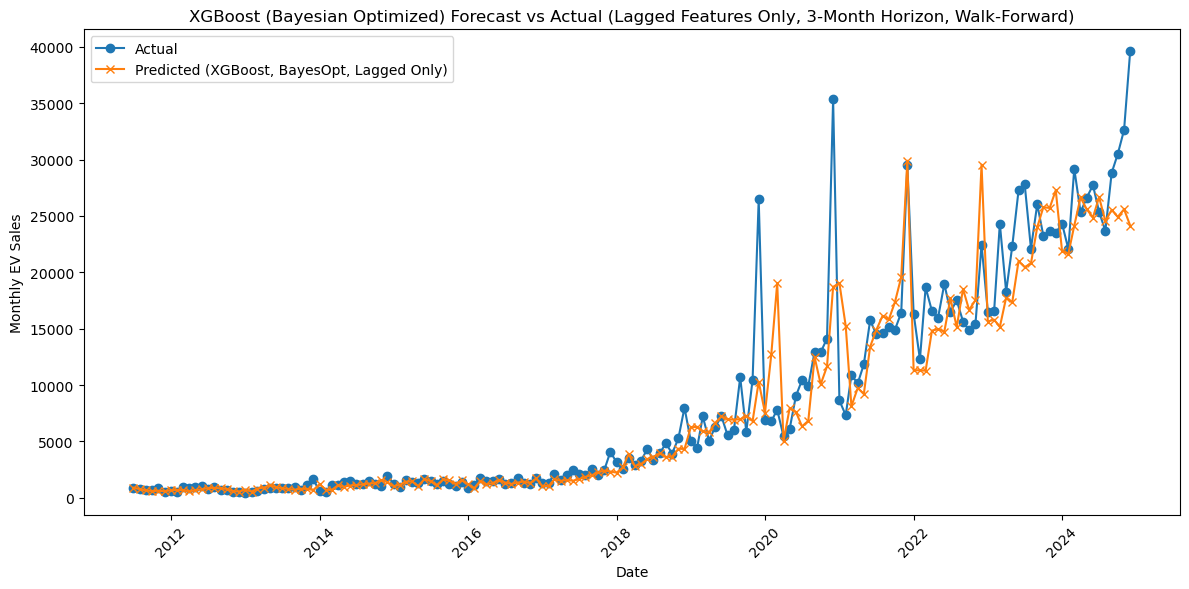

In [55]:
# Use only lagged features
X = df_lagged[lagged_features].values
y = df_lagged[target_col].values

from bayes_opt import BayesianOptimization
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

# Split train/val (last 10% of training as validation)
n_train = int(len(train) * 0.9)
X_train, X_val = X[:n_train], X[n_train:len(train)]
y_train, y_val = y[:n_train], y[n_train:len(train)]

def xgb_val_rmse(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    return -rmse  # negative because BayesianOptimization maximizes

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_val_rmse,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)

# Walk-forward validation with lagged features only (on full train+val)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_tr = X[:i]
    y_tr = y[:i]
    X_te = X[i:i + forecast_horizon]
    y_te = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    predictions.extend(y_pred)
    actuals.extend(y_te)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (Bayesian Optimized on Validation, 3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, BayesOpt, Lagged Only)', marker='x')
plt.title('XGBoost (Bayesian Optimized) Forecast vs Actual (Lagged Features Only, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -5.313e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -5.321e+0 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -5.335e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -5.207e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -5.21e+03 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -5.585e+0 | 0.7583    | 0.2976    | 2.328     | 172.8     | 0.5457    |
| 7         | -5.356e+0 | 0.5875    | 0.2942    | 7.931     | 149.6     | 0.9939    |
| 8         | -7.294e+0 | 1.0       | 0.01      | 2.0       | 135.4     | 0.5       |
| 9         | -6.683e+0 | 0.6756    | 0.01      | 2.775     | 146.2     | 0.82      |
| 10        | -5.016e+0 | 0.8914    | 0.08425   | 6.30

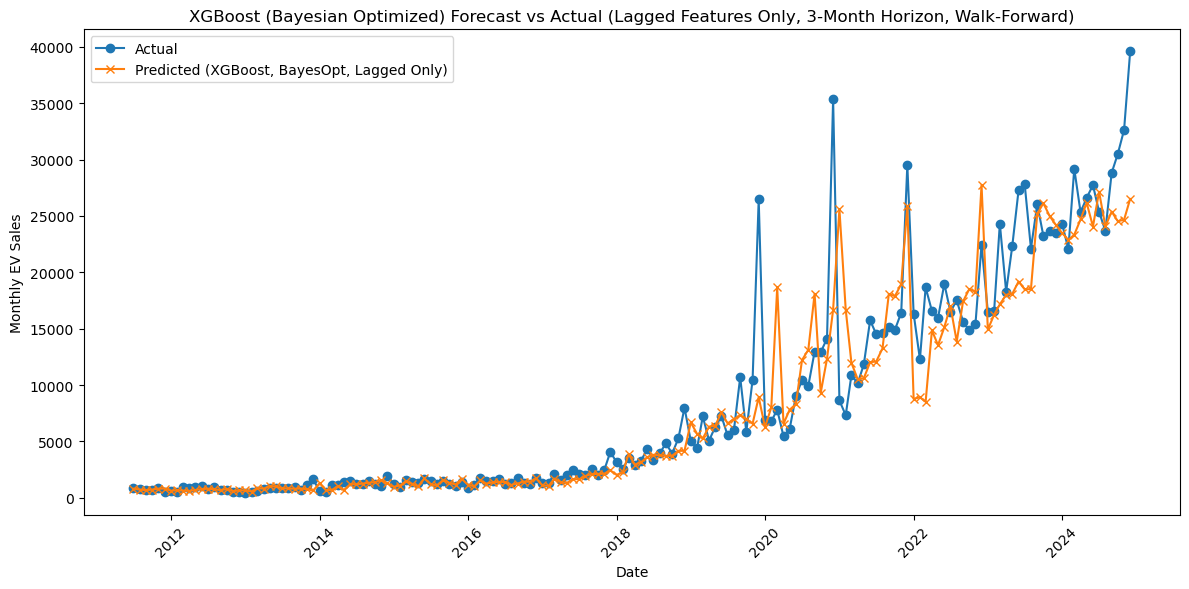

In [14]:
# Use only lagged features
X = df_lagged[lagged_features].values
y = df_lagged[target_col].values

# The rest of the code remains unchanged
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np

def xgb_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
    return scores.mean()

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)

# Walk-forward validation with lagged features only
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (Bayesian Optimized, 3-month horizon, Lagged Features Only):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, BayesOpt, Lagged Only)', marker='x')
plt.title('XGBoost (Bayesian Optimized) Forecast vs Actual (Lagged Features Only, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  1818.816162  3674.526228  0.850110  0.219678
1    Keywords + Lag  1908.719849  3819.682840  0.838033  0.226354
2  Bijtelling + Lag  1795.165649  3629.520630  0.853759  0.212595
3  Confidence + Lag  1844.459473  3583.526475  0.857442  0.225192
4        Fuel + Lag  1829.298828  3795.026614  0.840118  0.225938
5      All Features  2167.548340  4350.077011  0.789930  0.248515


<Figure size 1200x600 with 0 Axes>

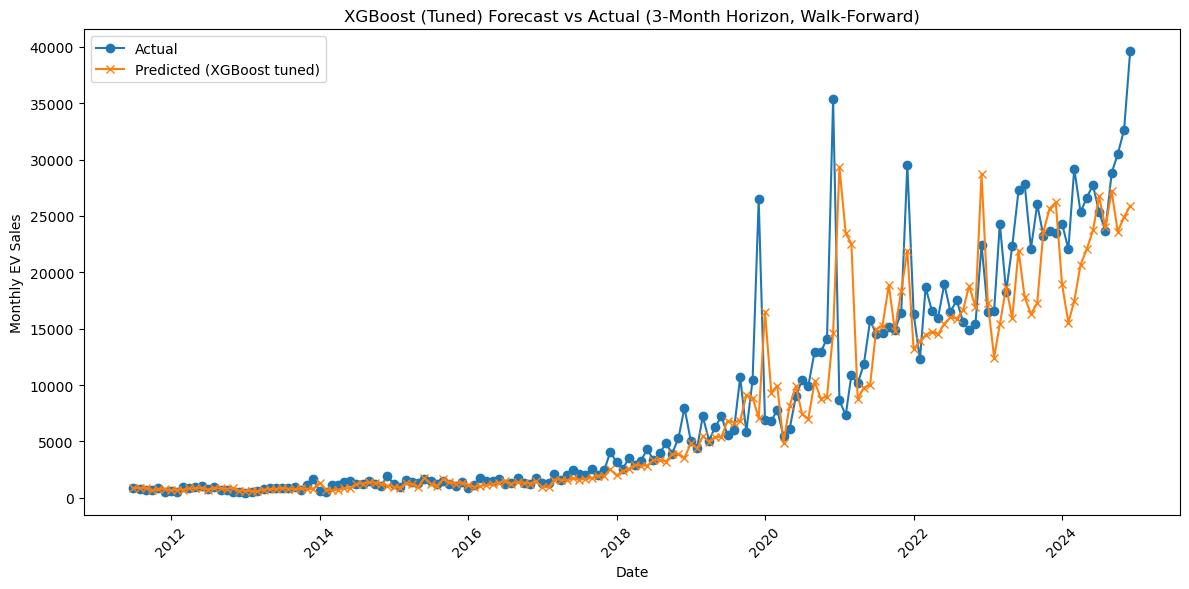

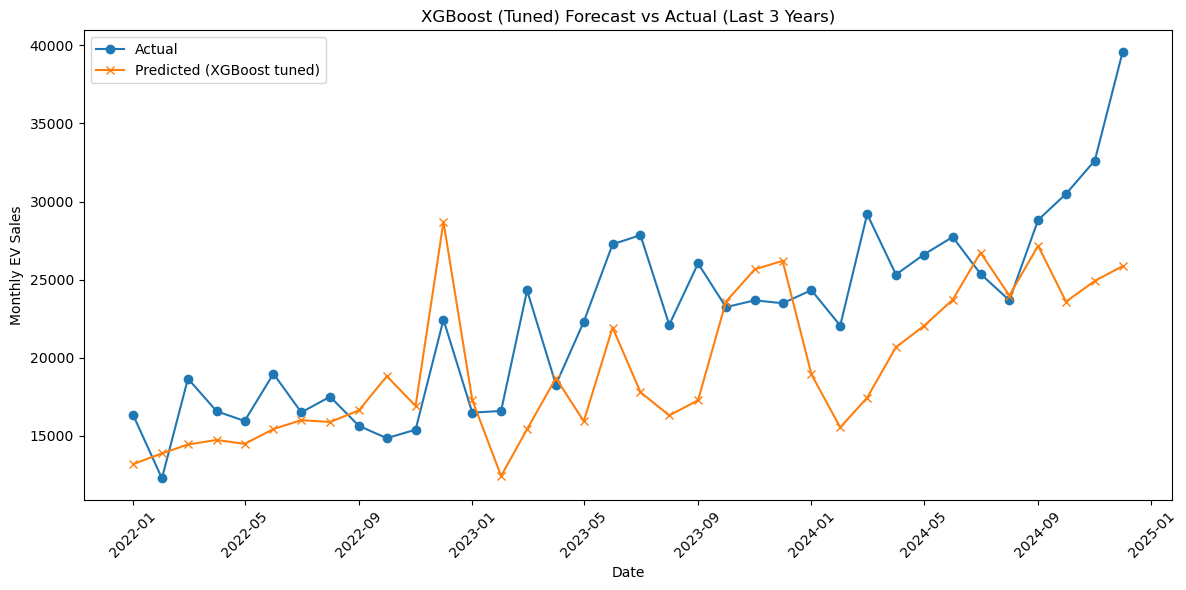

In [15]:
results = []

for name, features in feature_sets.items():
    X = df_lagged[features].values
    y = df_lagged[target_col].values
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]

        model = xgb.XGBRegressor(
            colsample_bytree=best_params['colsample_bytree'],
            learning_rate=best_params['learning_rate'],
            max_depth=int(best_params['max_depth']),
            n_estimators=int(best_params['n_estimators']),
            subsample=best_params['subsample'],
            objective='reg:squarederror',
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) 

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost tuned)', marker='x')
plt.title('XGBoost (Tuned) Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost tuned)', marker='x')
plt.title('XGBoost (Tuned) Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Arimax

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

Best ARIMAX order: (3, 1, 4)
ARIMAX (auto_arima, Lagged Features Only, Validation):
MAE: 7010.73
RMSE: 7961.39
R²: -2.4222
MAPE: 0.25


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


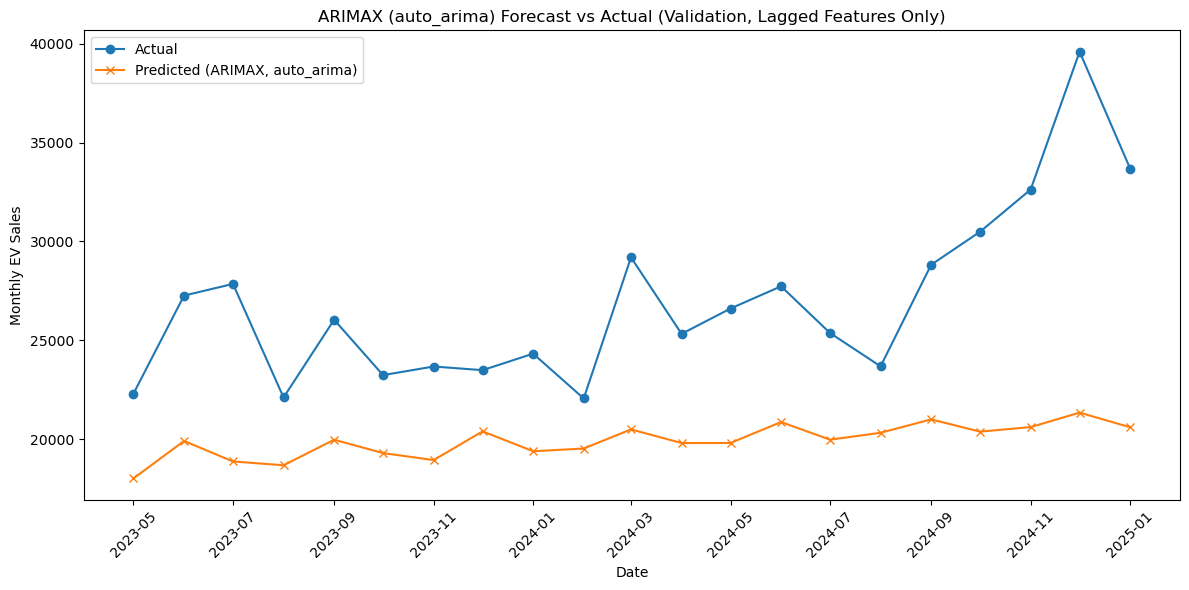

In [60]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use only lagged features as exogenous variables
exog = df_lagged[lagged_features].values
y = df_lagged[target_col].values

# Define validation size (10% of the data)
validation_size = int(0.1 * len(df_lagged))
train_size = len(df_lagged) - validation_size

# Split train/validation
y_train, y_val = y[:train_size], y[train_size:]
exog_train, exog_val = exog[:train_size], exog[train_size:]

# Fit auto_arima on the training data
arimax_model = auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print("Best ARIMAX order:", arimax_model.order)

# Predict on validation set
y_val_pred = arimax_model.predict(n_periods=validation_size, exogenous=exog_val)

# Evaluate
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val))

print("ARIMAX (auto_arima, Lagged Features Only, Validation):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")



# hyperparameter tuning all features just xgboost 

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -5.218e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -5.129e+0 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -5.345e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -5.014e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -5.068e+0 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -5.001e+0 | 0.8866    | 0.2196    | 6.595     | 157.7     | 0.9969    |
| 7         | -6.48e+03 | 0.8549    | 0.01019   | 5.752     | 154.8     | 0.8548    |
| 8         | -5.009e+0 | 0.8082    | 0.2916    | 6.406     | 159.6     | 0.8125    |
| 9         | -5.073e+0 | 0.9785    | 0.1682    | 3.178     | 160.4     | 0.7903    |
| 10        | -5.101e+0 | 0.7565    | 0.04139   | 4.94

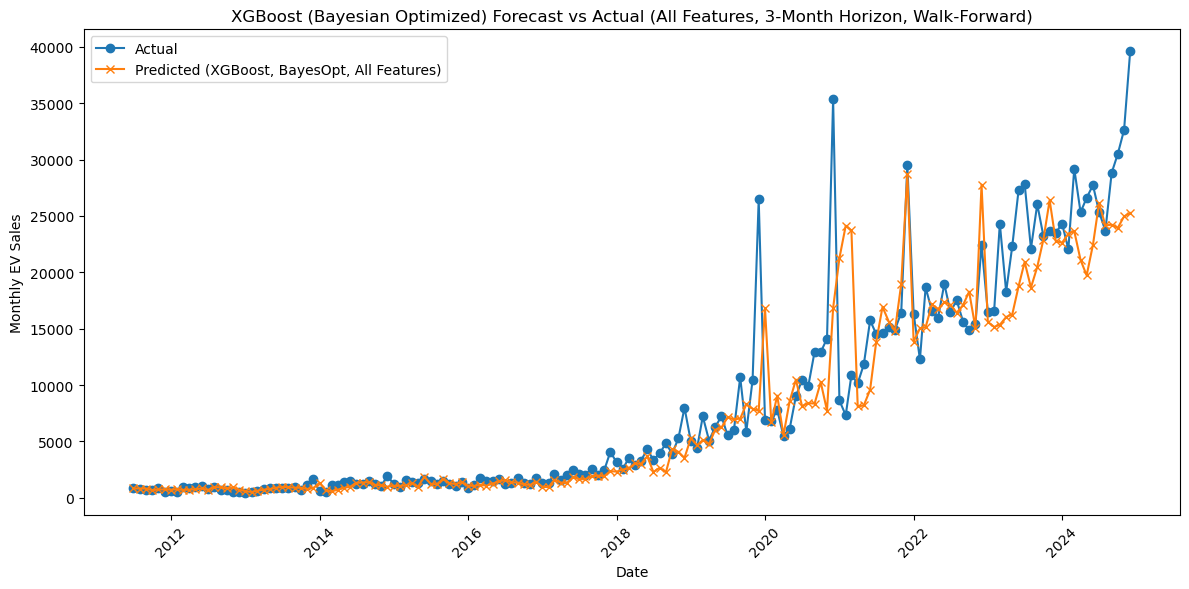

In [16]:
# Use all features for X and y
X = df_lagged[all_features].values
y = df_lagged[target_col].values

def xgb_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
    return scores.mean()

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)

# Walk-forward validation with all features
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (Bayesian Optimized, 3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, BayesOpt, All Features)', marker='x')
plt.title('XGBoost (Bayesian Optimized) Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Arimax

In [17]:
import pmdarima as pm

# Fit auto_arima on the training set with exogenous variables
autoarima_model = pm.auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

# Forecast for the test set
y_pred = autoarima_model.predict(n_periods=forecast_horizon, exogenous=exog_test)

print("AutoARIMA predictions:", y_pred)
print("Actual values:", y_test)


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

AutoARIMA predictions: [26513.92719975 26643.41647778 26772.90575581]
Actual values: [30491 32623 39594]


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
print("y_train shape:", y_train.shape)
print("exog_train shape:", exog_train.shape)
print("exog_test shape:", exog_test.shape)
print("forecast_horizon:", forecast_horizon)
print("y_test shape:", y_test.shape)
print(autoarima_model.summary())


y_train shape: (207,)
exog_train shape: (207, 27)
exog_test shape: (3, 27)
forecast_horizon: 3
y_test shape: (3,)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1937.569
Date:                Sun, 08 Jun 2025   AIC                           3881.139
Time:                        21:51:42   BIC                           3891.122
Sample:                             0   HQIC                          3885.176
                                - 207                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    129.4893     87.413      1.481      0.139     -41.838     300.816
ma.L1         -0.

In [19]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

orders = [(2,1,2), (1,1,1), (3,1,2)]
best_mape = float('inf')
best_order = None
best_predictions = None
best_actuals = None

for order in orders:
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i + forecast_horizon]
        y_test = y[i:i + forecast_horizon]
        try:
            model = SARIMAX(y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+forecast_horizon-1, exog=X_test)
        except Exception:
            y_pred = np.full(forecast_horizon, np.mean(y_train))
        predictions.extend(y_pred)
        actuals.extend(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mape = np.mean(np.abs((actuals - predictions) / actuals))
    print(f"Order {order}: MAPE={mape:.4f}")
    if mape < best_mape:
        best_mape = mape
        best_order = order
        best_predictions = predictions
        best_actuals = actuals

print(f"\nBest ARIMAX order: {best_order} with MAPE={best_mape:.4f}")


Order (2, 1, 2): MAPE=2.4051
Order (1, 1, 1): MAPE=518.4252
Order (3, 1, 2): MAPE=1.2919

Best ARIMAX order: (3, 1, 2) with MAPE=1.2919


ARIMAX (order=(3,1,2), 3-month horizon, All Features):
MAE: 15537.90
RMSE: 125571.85
R²: -174.0474
MAPE: 1.29


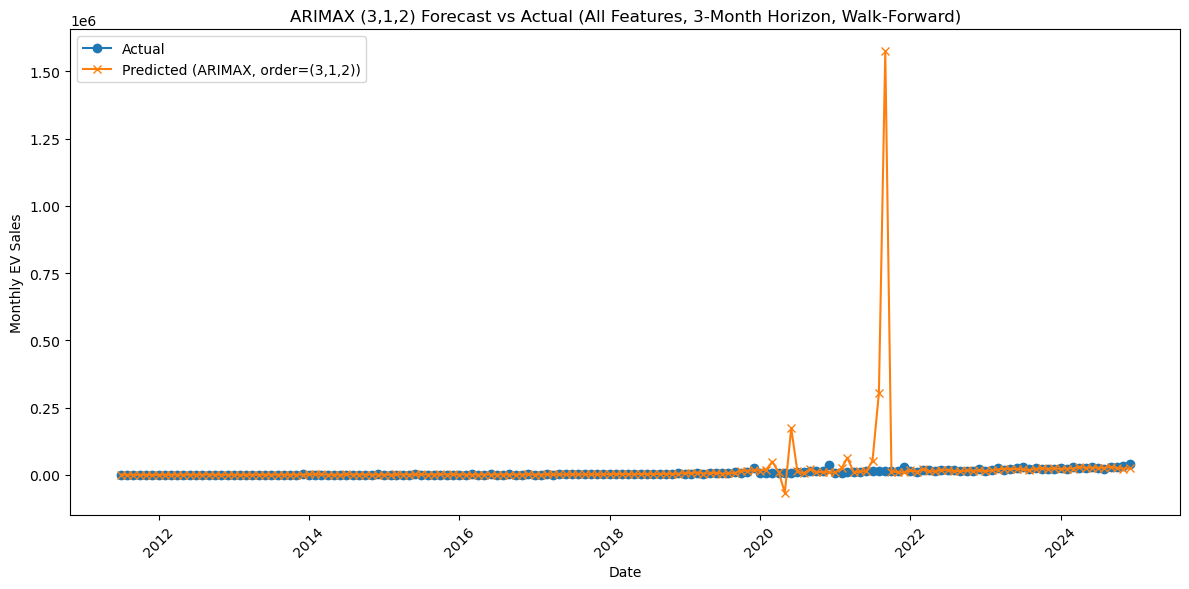

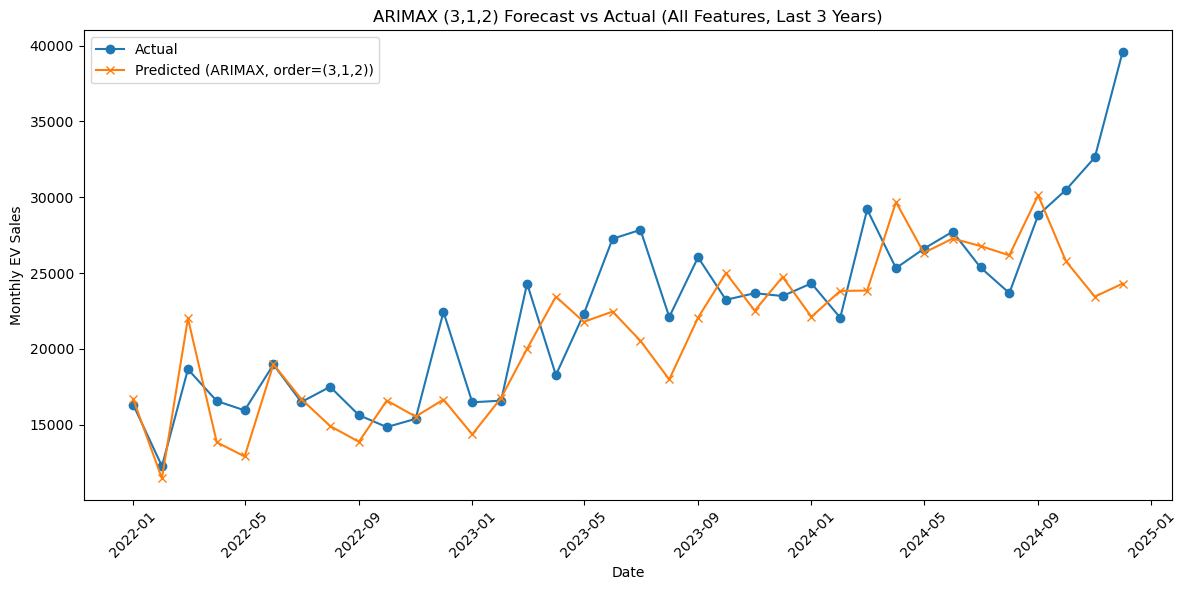

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use ARIMAX with order (3, 1, 2)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    y_train = y[:i]
    y_test = y[i:i + forecast_horizon]
    exog_train = X[:i]
    exog_test = X[i:i + forecast_horizon]

    try:
        model = SARIMAX(y_train, exog=exog_train, order=(3, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
    except Exception:
        y_pred = np.full(forecast_horizon, np.mean(y_train))

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("ARIMAX (order=(3,1,2), 3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX, order=(3,1,2))', marker='x')
plt.title('ARIMAX (3,1,2) Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX, order=(3,1,2))', marker='x')
plt.title('ARIMAX (3,1,2) Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


ARIMAX (3-month horizon, All Features):
MAE: 2301.90
RMSE: 5006.99
R²: 0.7217
MAPE: 0.31


<Figure size 1200x600 with 0 Axes>

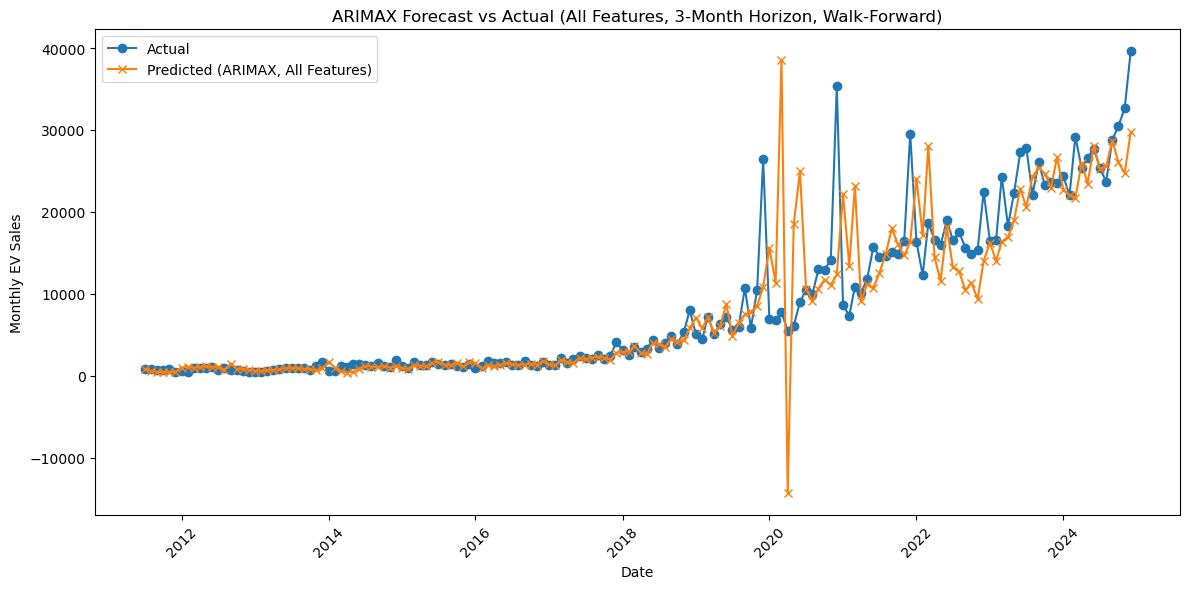

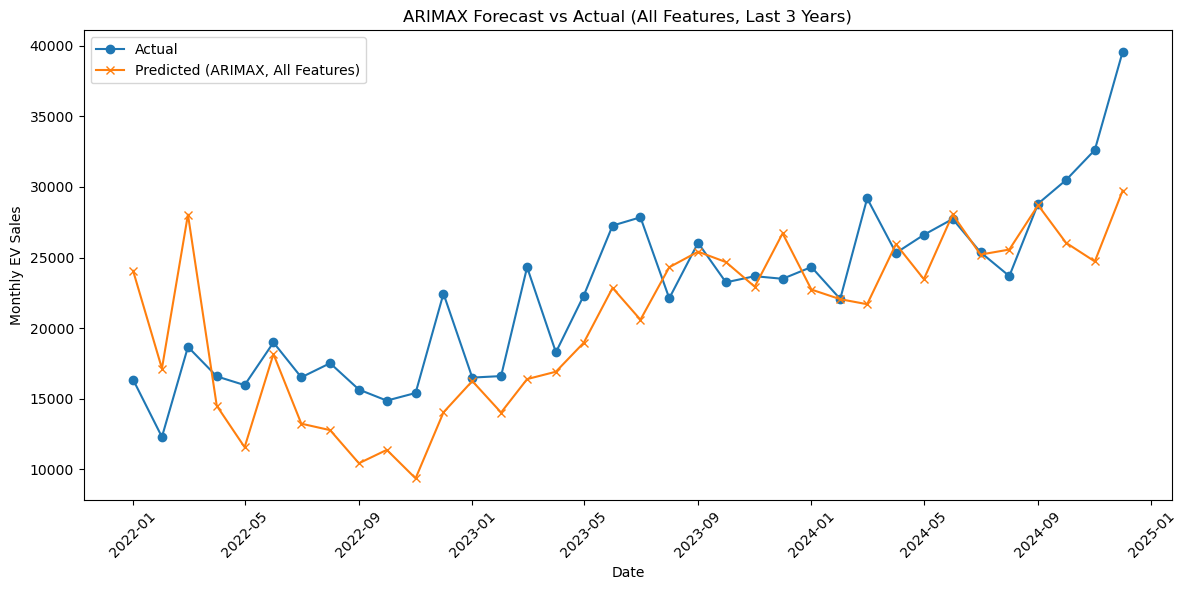

In [22]:
# Use ARIMAX (SARIMAX with exogenous variables) instead of XGBoost

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    y_train = y[:i]
    y_test = y[i:i + forecast_horizon]
    exog_train = X[:i]
    exog_test = X[i:i + forecast_horizon]

    try:
        model = SARIMAX(y_train, exog=exog_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
    except Exception:
        y_pred = np.full(forecast_horizon, np.mean(y_train))

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("ARIMAX (3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])
plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX, All Features)', marker='x')
plt.title('ARIMAX Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX, All Features)', marker='x')
plt.title('ARIMAX Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


All features optim:

In [23]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Use all features for X and y
X = df_lagged[all_features].values
y = df_lagged[target_col].values

def xgb_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
    return scores.mean()

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -5.218e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -5.129e+0 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -5.345e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -5.014e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -5.068e+0 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -5.001e+0 | 0.8866    | 0.2196    | 6.595     | 157.7     | 0.9969    |
| 7         | -6.48e+03 | 0.8549    | 0.01019   | 5.752     | 154.8     | 0.8548    |
| 8         | -5.009e+0 | 0.8082    | 0.2916    | 6.406     | 159.6     | 0.8125    |
| 9         | -5.073e+0 | 0.9785    | 0.1682    | 3.178     | 160.4     | 0.7903    |
| 10        | -5.101e+0 | 0.7565    | 0.04139   | 4.94

              Model          MAE         RMSE        R²      MAPE
0        (Lag Only)  1789.619751  3626.008136  0.854042  0.230313
1    Keywords + Lag  1755.347168  3584.660095  0.857352  0.217982
2  Bijtelling + Lag  1726.209106  3415.984338  0.870460  0.217843
3  Confidence + Lag  1834.216187  3753.062616  0.843634  0.226260
4        Fuel + Lag  1761.009277  3687.056956  0.849086  0.228232
5      All Features  1929.261719  3898.402237  0.831289  0.236595


<Figure size 1200x600 with 0 Axes>

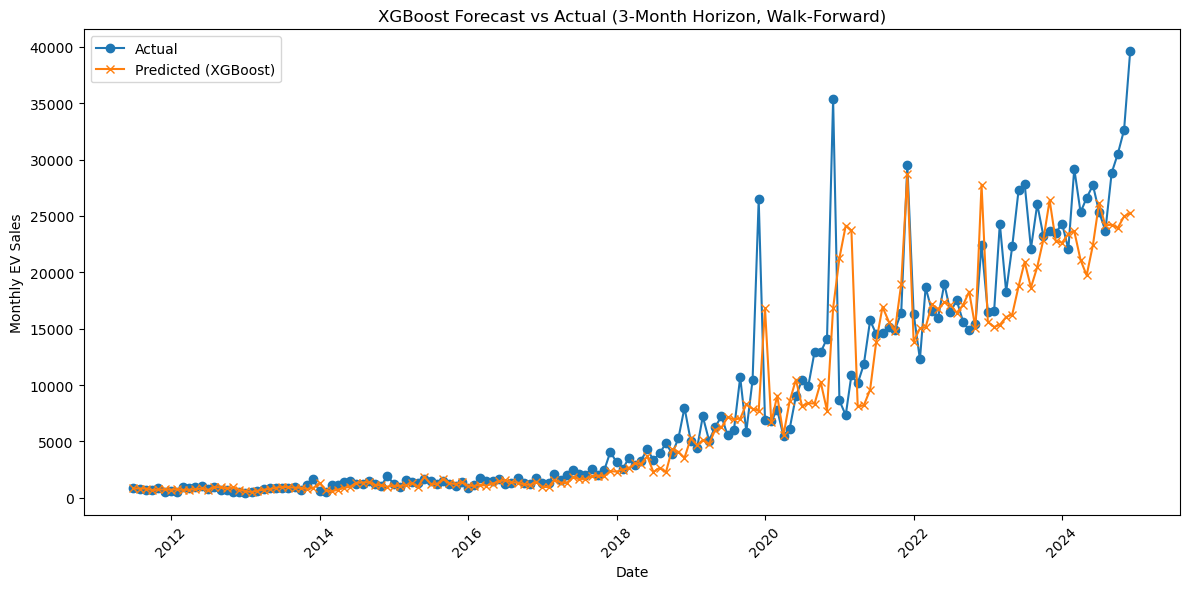

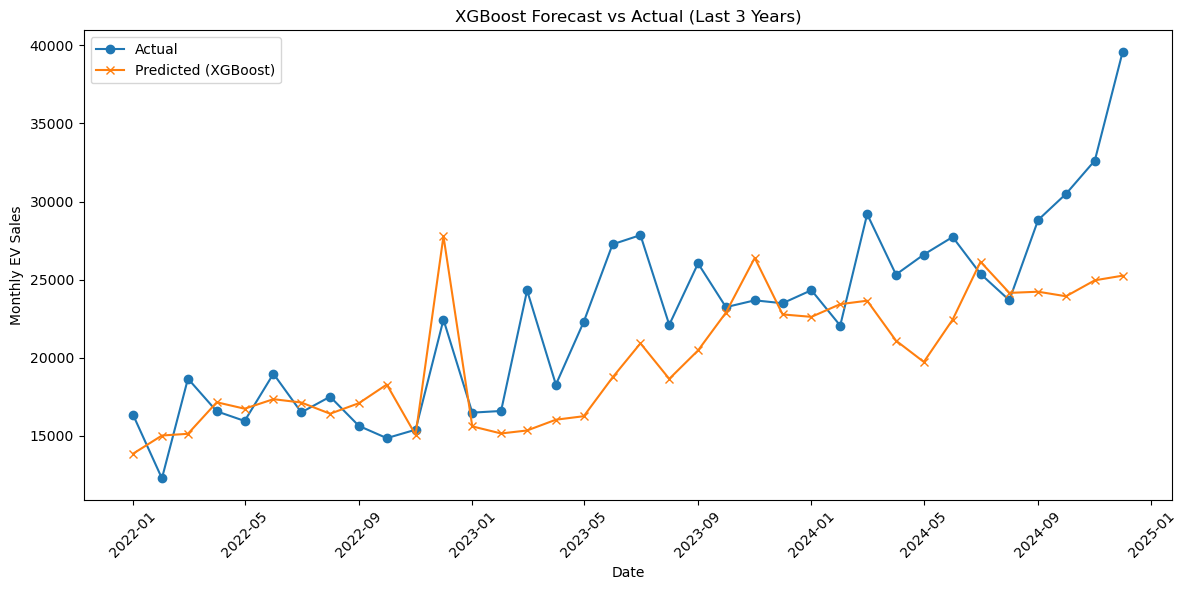

In [49]:
import xgboost as xgb

xgb_params = {
    'colsample_bytree': 0.8866212516394074,
    'learning_rate': 0.21962635692143415,
    'max_depth': 6,
    'n_estimators': 157,
    'subsample': 0.9968760729626955,
    'objective': 'reg:squarederror',
    'random_state': 42
}

results = []

for name, features in feature_sets.items():
    X = df_lagged[features].values
    y = df_lagged[target_col].values
    predictions, actuals = [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]

        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) 

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])

# Calculate how many test periods there are
test_periods = []
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    test_periods.extend(df_lagged['Periode'].iloc[i:i+forecast_horizon])

plot_index = pd.to_datetime(test_periods)

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost Forecast vs Actual (3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost Forecast vs Actual (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


XGBoost (Optimized, 3-month horizon, All Features):
MAE: 1929.26
RMSE: 3898.40
R²: 0.8313
MAPE: 0.24


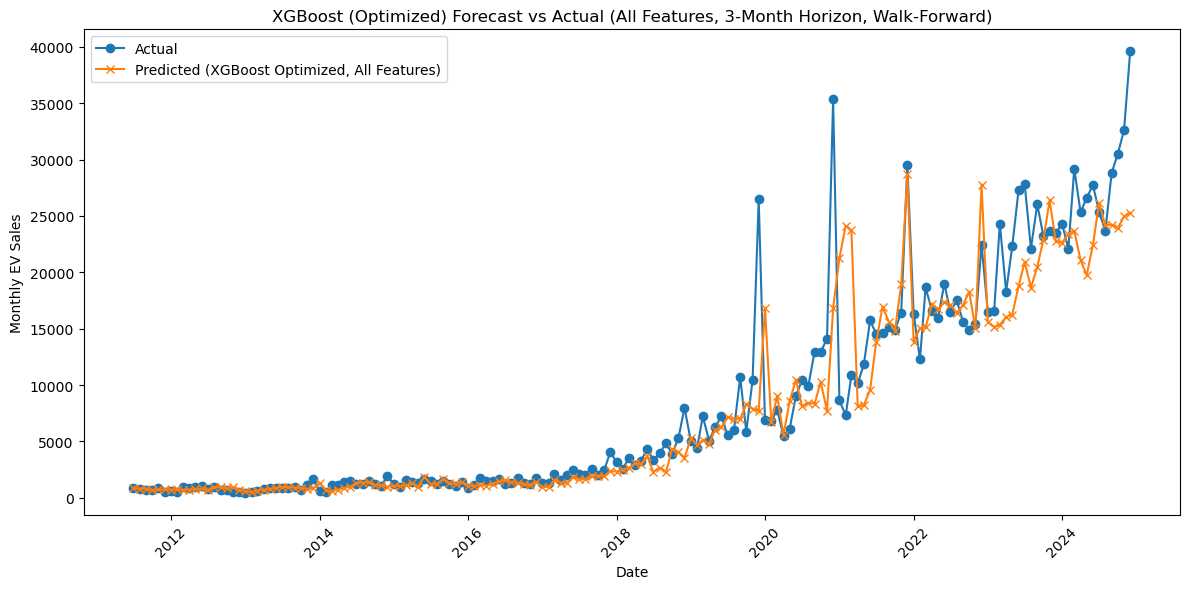

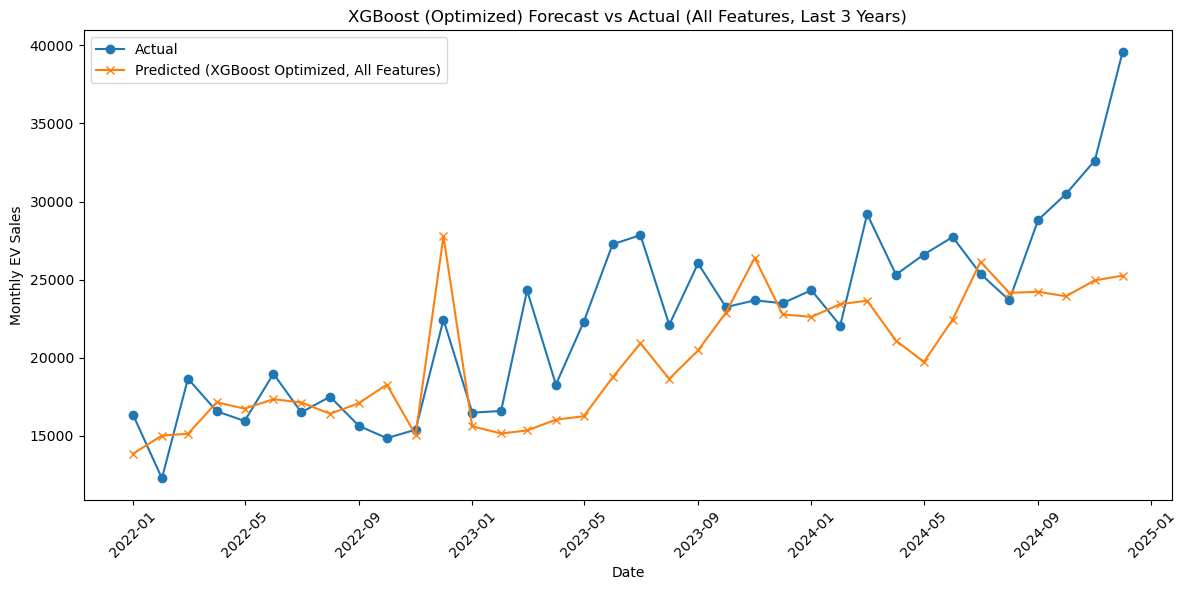

In [24]:
# Use XGBoost with the provided optimized parameters
xgb_params = {
    'colsample_bytree': 0.8866212516394074,
    'learning_rate': 0.21962635692143415,
    'max_depth': 6,
    'n_estimators': 157,
    'subsample': 0.9968760729626955,
    'objective': 'reg:squarederror',
    'random_state': 42
}

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (Optimized, 3-month horizon, All Features):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost Optimized, All Features)', marker='x')
plt.title('XGBoost (Optimized) Forecast vs Actual (All Features, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost Optimized, All Features)', marker='x')
plt.title('XGBoost (Optimized) Forecast vs Actual (All Features, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Shap analays

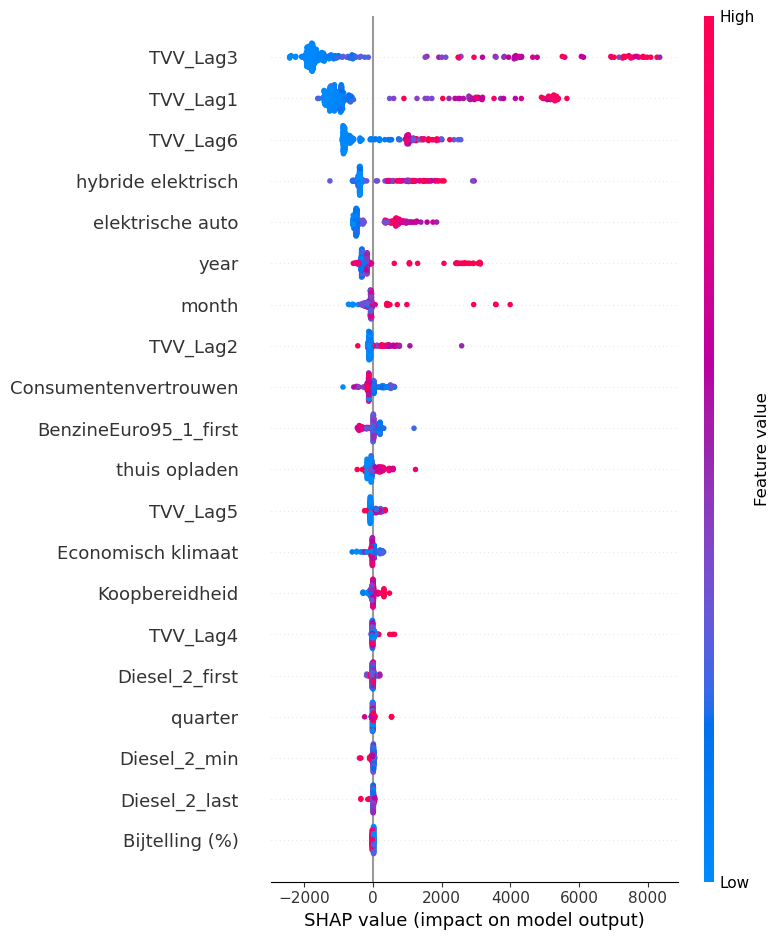

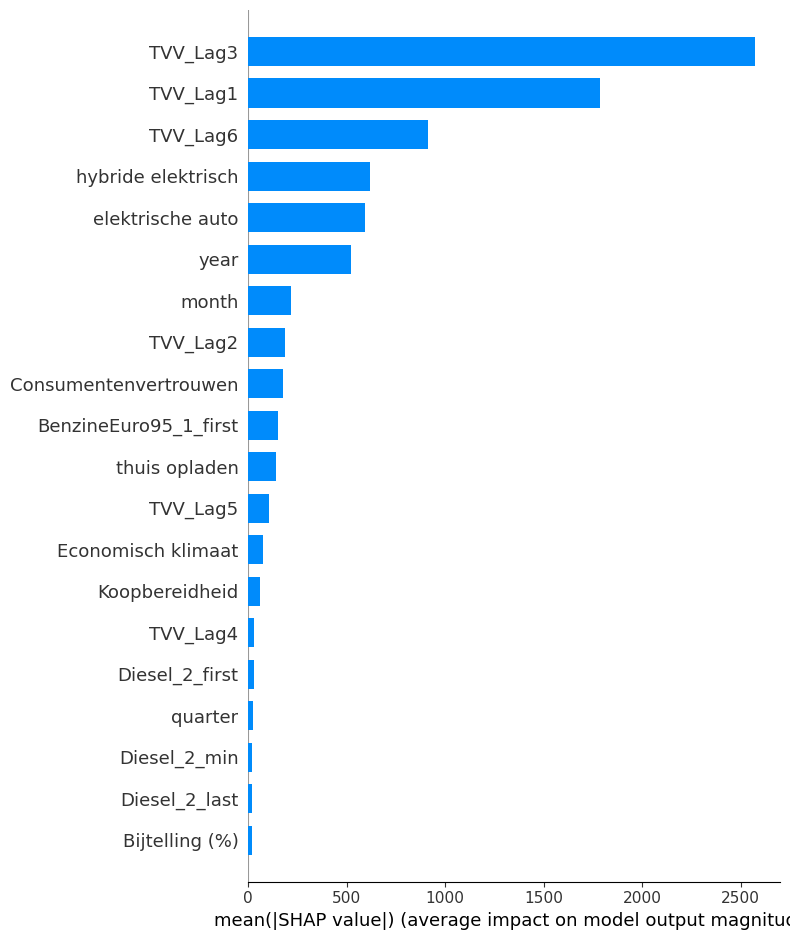

In [25]:
import shap

# Use the optimized XGBoost model and all features for SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot for all features
shap.summary_plot(shap_values, features=X, feature_names=all_features)

# Optional: summary bar plot
shap.summary_plot(shap_values, features=X, feature_names=all_features, plot_type="bar")

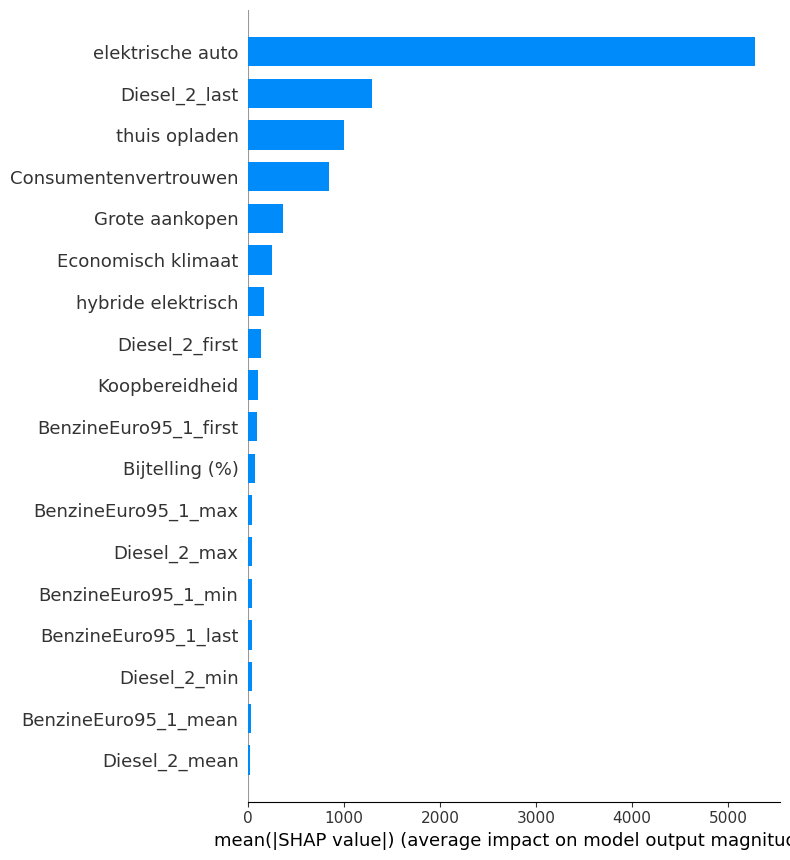

In [50]:
import shap

# Exclude lagged features from the feature list
non_lagged_features = [f for f in all_features if f not in lagged_features]

# Prepare data without lagged features
X_non_lagged = df_lagged[non_lagged_features].values

# Fit a new XGBoost model on non-lagged features
model_non_lagged = xgb.XGBRegressor(**xgb_params)
model_non_lagged.fit(X_non_lagged, y)

# SHAP analysis for non-lagged features
explainer_non_lagged = shap.Explainer(model_non_lagged, X_non_lagged)
shap_values_non_lagged = explainer_non_lagged(X_non_lagged)

# SHAP summary plot

shap.summary_plot(shap_values_non_lagged, features=X_non_lagged, feature_names=non_lagged_features,  plot_type="bar")

In [29]:
# Calculate mean absolute SHAP values for non-lagged features (global importance)
mean_abs_shap_non_lagged = np.abs(shap_values_non_lagged.values).mean(axis=0)
feature_importance_non_lagged = sorted(zip(non_lagged_features, mean_abs_shap_non_lagged), key=lambda x: x[1], reverse=True)

# Print sorted features by global importance (non-lagged only)
for feat, importance in feature_importance_non_lagged:
    print(f"{feat}: {importance:.2f}")

elektrische auto: 5277.58
Diesel_2_last: 1293.38
thuis opladen: 998.90
Consumentenvertrouwen: 843.91
Grote aankopen: 357.84
Economisch klimaat: 243.02
hybride elektrisch: 165.51
Diesel_2_first: 131.80
Koopbereidheid: 103.87
BenzineEuro95_1_first: 92.32
Bijtelling (%): 70.16
BenzineEuro95_1_max: 42.01
Diesel_2_max: 41.97
BenzineEuro95_1_min: 40.64
BenzineEuro95_1_last: 39.47
Diesel_2_min: 34.92
BenzineEuro95_1_mean: 26.24
Diesel_2_mean: 20.60


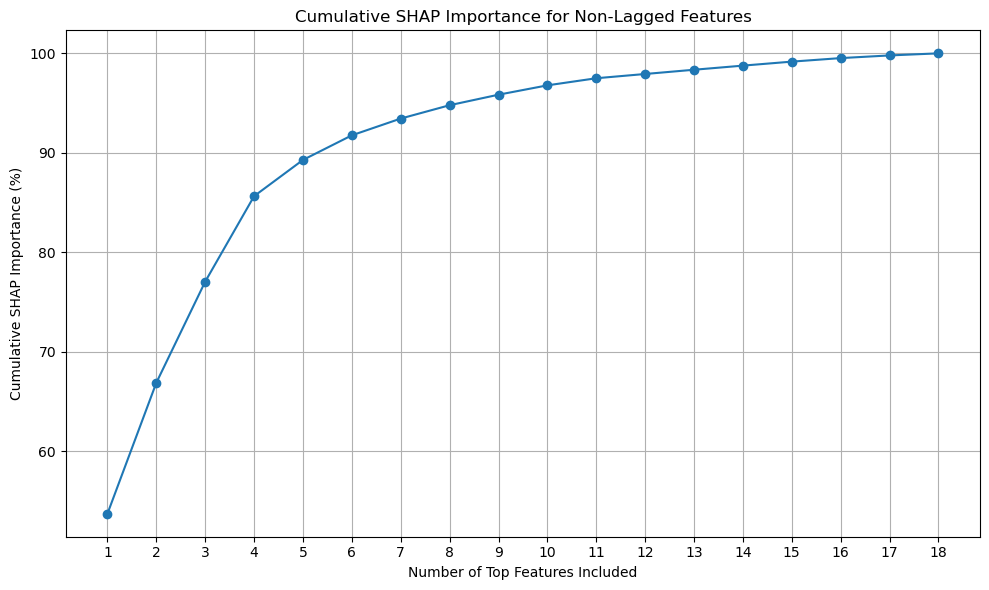

In [30]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate cumulative sum of mean absolute SHAP values for non-lagged features
mean_abs_shap_sorted = np.array([imp for _, imp in feature_importance_non_lagged])
cumulative_shap = np.cumsum(mean_abs_shap_sorted)
cumulative_shap_percent = cumulative_shap / cumulative_shap[-1] * 100

# Plot cumulative SHAP importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_abs_shap_sorted) + 1), cumulative_shap_percent, marker='o')
plt.xlabel('Number of Top Features Included')
plt.ylabel('Cumulative SHAP Importance (%)')
plt.title('Cumulative SHAP Importance for Non-Lagged Features')
plt.grid(True)
plt.xticks(range(1, len(mean_abs_shap_sorted) + 1))
plt.tight_layout()
plt.show()

In [31]:
shap_top_contextual = [
    'elektrische auto',
    'Diesel_2_last',
    'thuis opladen',
    'Consumentenvertrouwen',
    'Grote aankopen',
    'Economisch klimaat'
]

## hyperparameter optimalsiation on Shap

### Linear regression

Linear Regression (3-month horizon, SHAP contextual + lagged):
MAE: 2119.58
RMSE: 4804.85
R²: 0.7437
MAPE: 0.28


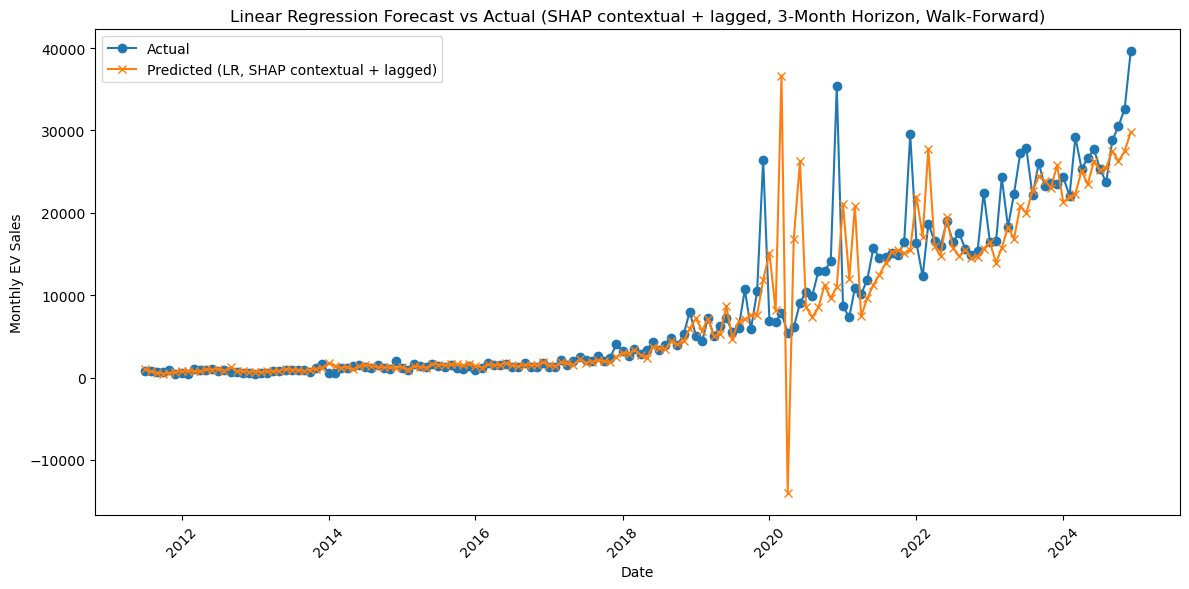

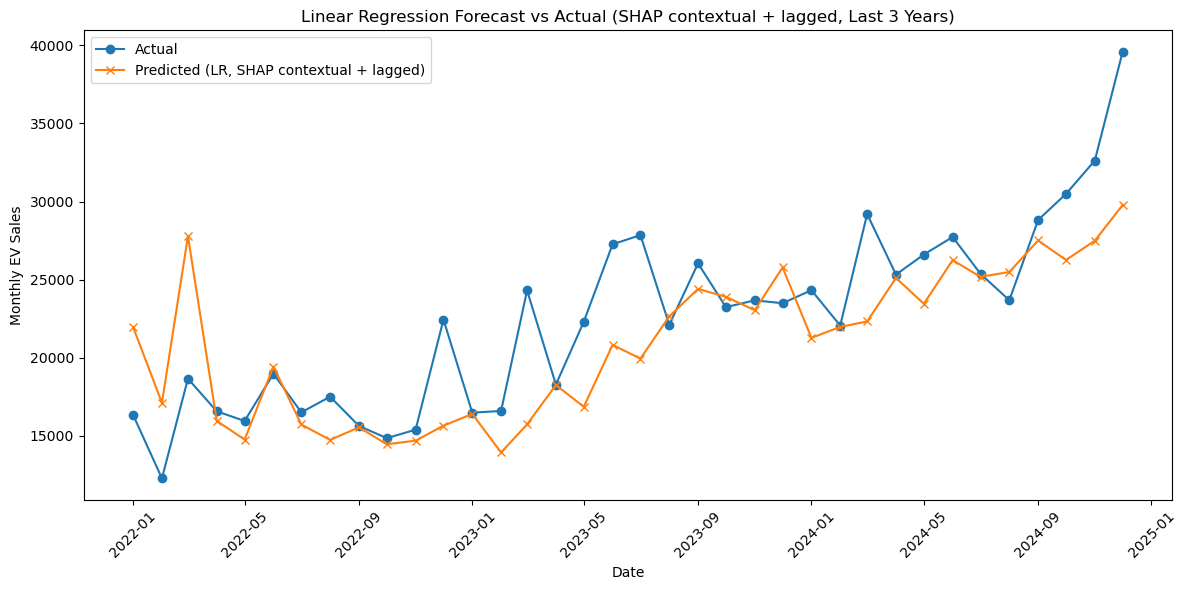

In [32]:
from sklearn.linear_model import LinearRegression

# Combine shap_top_contextual with lagged_features
contextual_lagged_features = shap_top_contextual + lagged_features

X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("Linear Regression (3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR, SHAP contextual + lagged)', marker='x')
plt.title('Linear Regression Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR, SHAP contextual + lagged)', marker='x')
plt.title('Linear Regression Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Xgboost


With Val

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

# 1. Split train into train/validation (90%/10%)
X_full = train[selected_feature_sets['All Features']].values
y_full = train[target_col].values

X_tr, X_val, y_tr, y_val = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, shuffle=False
)

# 2. Define Bayesian Optimization function using validation set
def xgb_val_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    return -np.sqrt(mean_squared_error(y_val, y_pred))  # negative RMSE for maximization

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_val_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)

# Evaluate on validation set
model = xgb.XGBRegressor(**best_params)
model.fit(X_tr, y_tr)
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val))

print("Validation set performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -8.771e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -9.531e+0 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -1.039e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -9.935e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -9.767e+0 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -1.002e+0 | 0.9118    | 0.1279    | 5.811     | 199.7     | 0.6373    |
| 7         | -9.883e+0 | 0.9532    | 0.04055   | 2.884     | 281.3     | 0.8854    |
| 8         | -1.082e+0 | 0.792     | 0.02386   | 2.215     | 76.13     | 0.6166    |
| 9         | -8.393e+0 | 0.7343    | 0.298     | 7.531     | 158.0     | 0.6578    |
| 10        | -9.477e+0 | 0.9038    | 0.06098   | 3.9 

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -5.225e+0 | 0.6873    | 0.2857    | 6.392     | 199.7     | 0.578     |
| 2         | -5.15e+03 | 0.578     | 0.02684   | 7.197     | 200.3     | 0.854     |
| 3         | -5.522e+0 | 0.5103    | 0.2913    | 6.995     | 103.1     | 0.5909    |
| 4         | -5.245e+0 | 0.5917    | 0.09823   | 5.149     | 158.0     | 0.6456    |
| 5         | -5.196e+0 | 0.8059    | 0.05045   | 3.753     | 141.6     | 0.728     |
| 6         | -5.907e+0 | 0.5       | 0.01      | 8.0       | 203.0     | 1.0       |
| 7         | -5.949e+0 | 0.5       | 0.01      | 8.0       | 198.9     | 1.0       |
| 8         | -5.066e+0 | 0.709     | 0.2138    | 6.322     | 200.3     | 0.9165    |
| 9         | -5.046e+0 | 0.7551    | 0.1694    | 5.045     | 201.0     | 0.901     |
| 10        | -5.137e+0 | 0.8905    | 0.1677    | 4.15

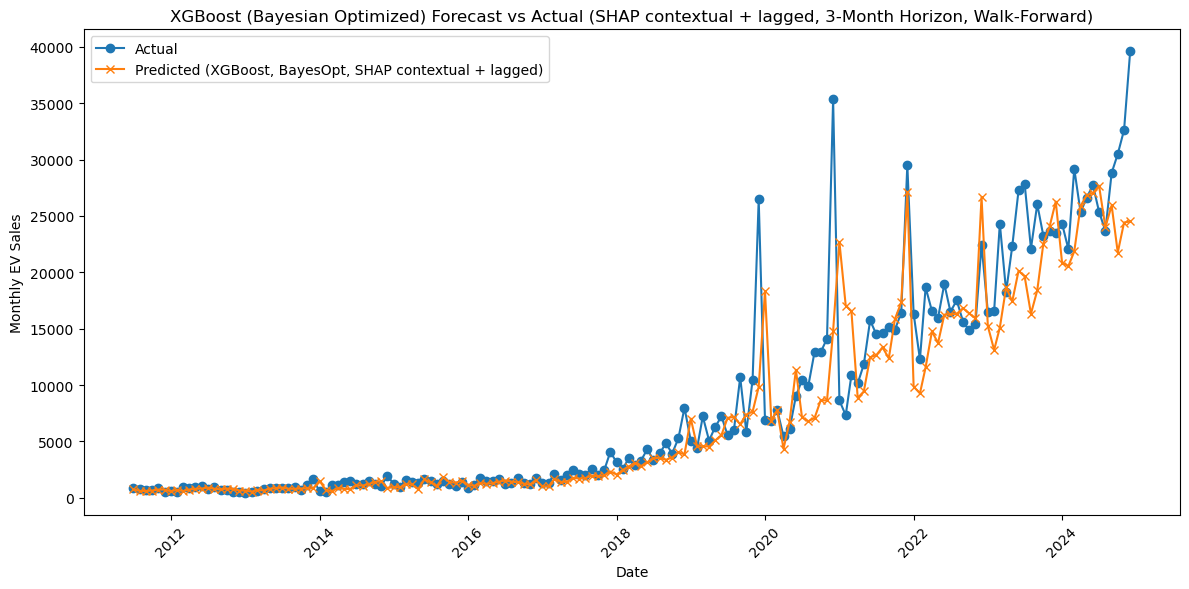

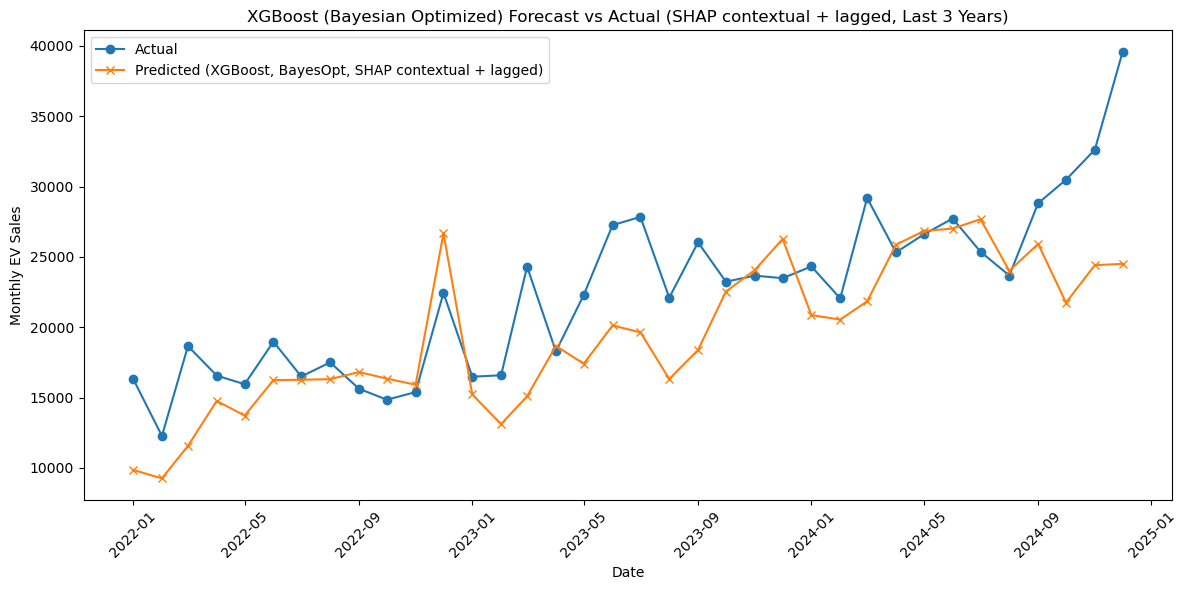

In [37]:
#  XGBoost SHAP contextual + lagged features
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Prepare data for contextual + lagged features
X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

def xgb_cv(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
    return scores.mean()

pbounds = {
    'max_depth': (2, 8),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

print("Best parameters found:", best_params)

# Walk-forward validation with optimized XGBoost
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (Bayesian Optimized, 3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, BayesOpt, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost (Bayesian Optimized) Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost, BayesOpt, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost (Bayesian Optimized) Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  XGBoost SHAP contextual + lagged features
import xgboost as xgb

X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


XGBoost (3-month horizon, SHAP contextual + lagged):
MAE: 1912.39
RMSE: 3785.78
R²: 0.8409
MAPE: 0.24


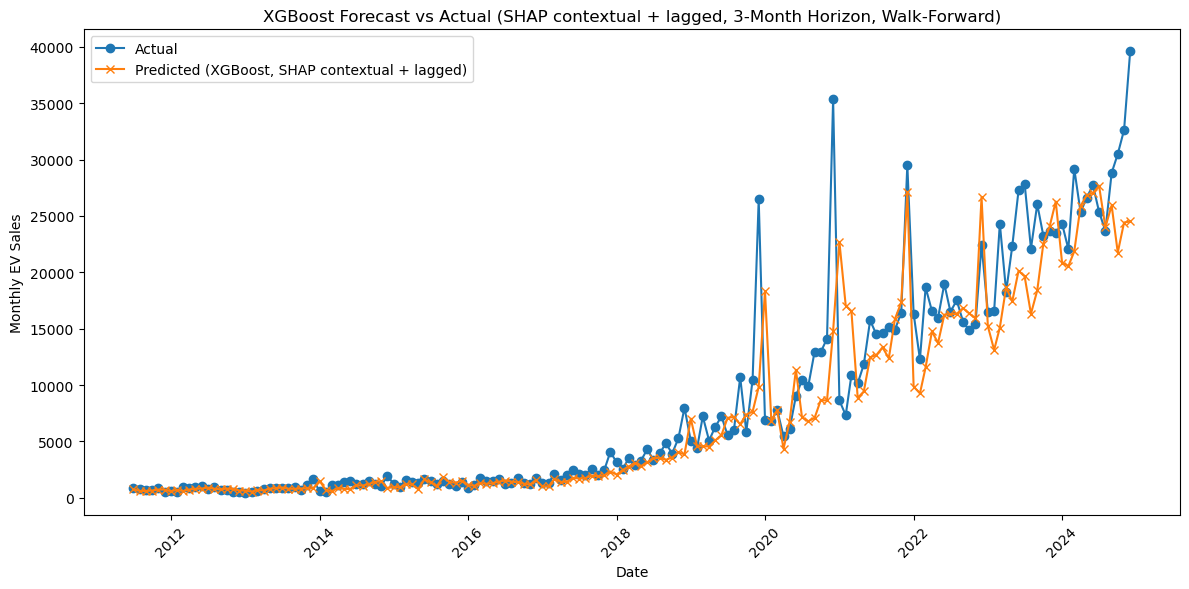

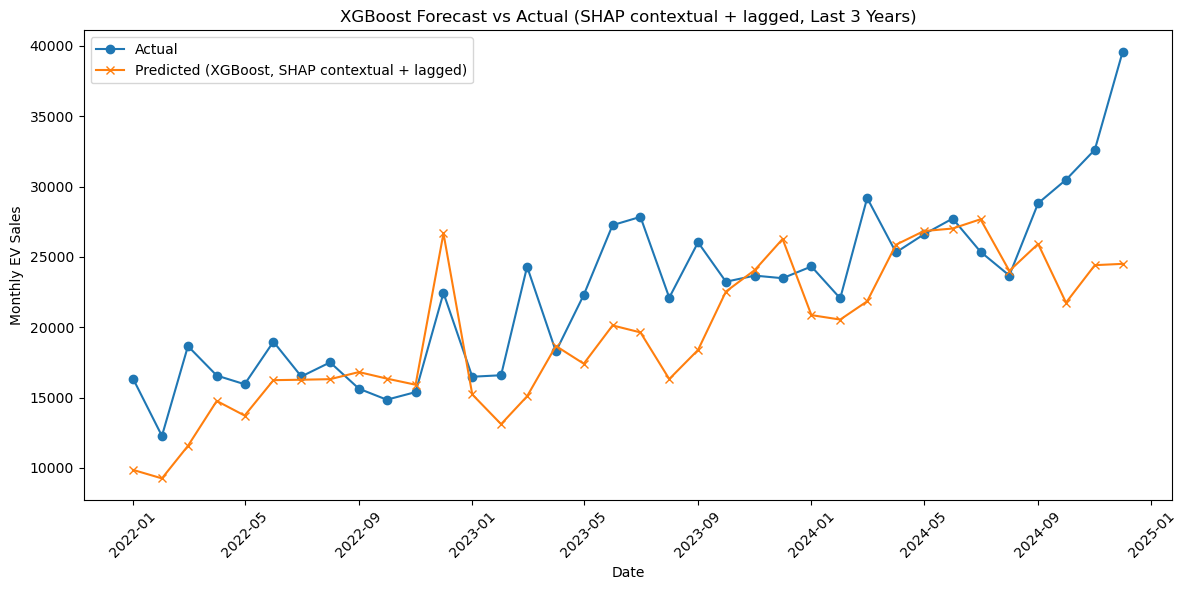

In [63]:
#  XGBoost SHAP contextual + lagged features
import xgboost as xgb

X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = xgb.XGBRegressor(
        colsample_bytree=0.7550582961145064,
        learning_rate=0.16940384585664167,
        max_depth=5,
        n_estimators=200,
        subsample=0.9010390708382912,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("XGBoost (3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (XGBoost, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (XGBoost, SHAP contextual + lagged)', marker='x')
plt.title('XGBoost Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Arimax

ARIMAX (3-month horizon, SHAP contextual + lagged):
MAE: 2120.45
RMSE: 4825.17
R²: 0.7415
MAPE: 0.29


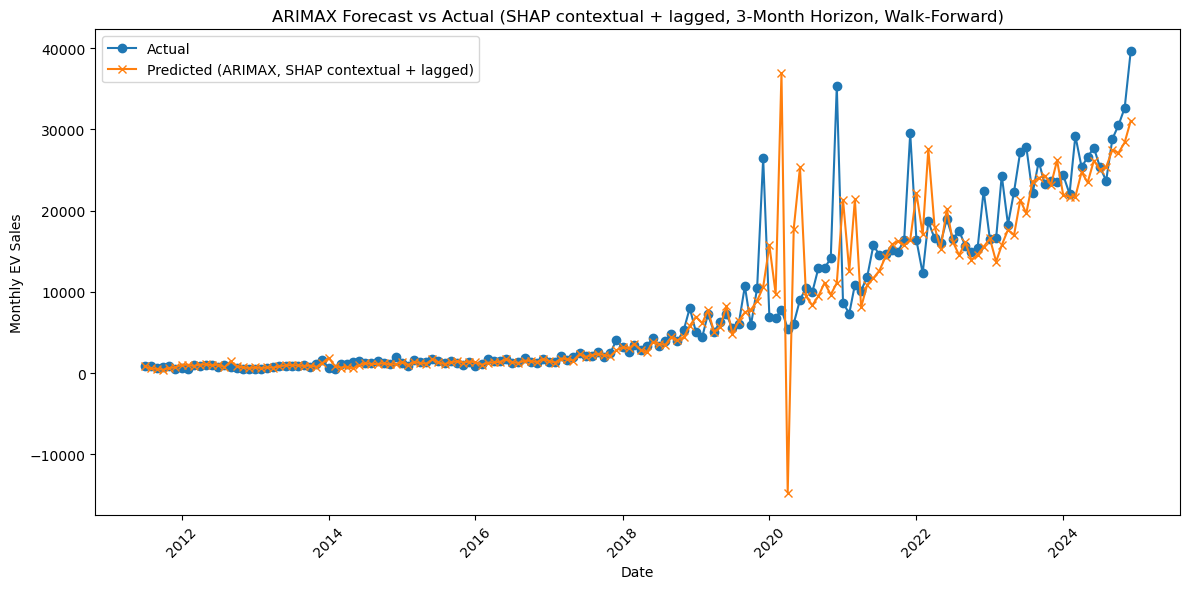

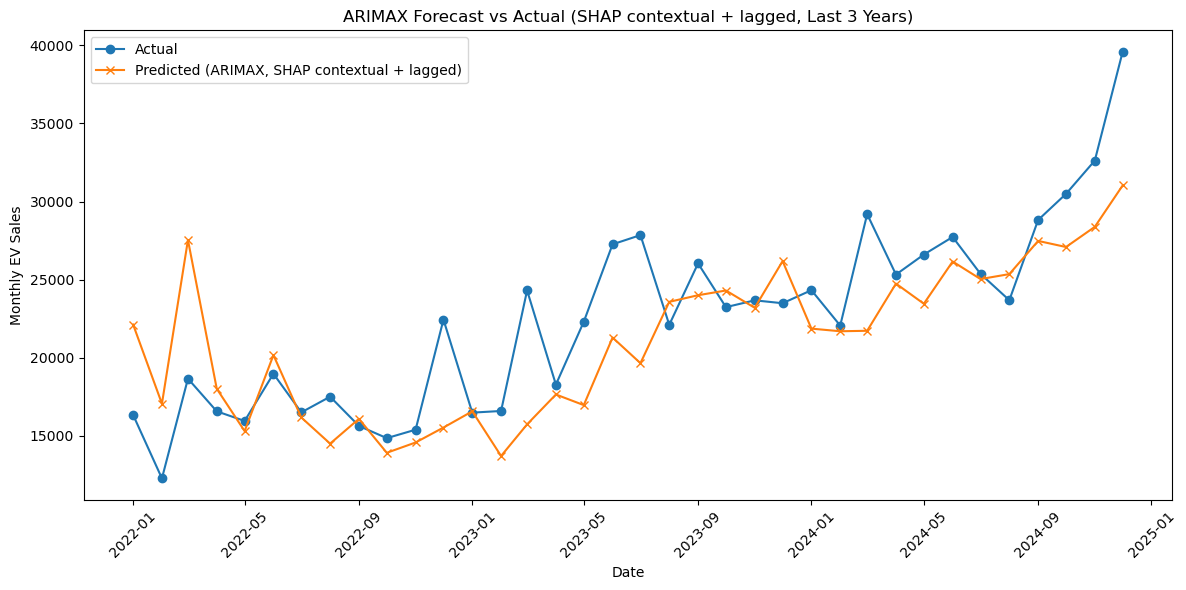

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Combine shap_top_contextual with lagged_features
contextual_lagged_features = shap_top_contextual + lagged_features

X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    y_train = y[:i]
    y_test = y[i:i + forecast_horizon]
    exog_train = X[:i]
    exog_test = X[i:i + forecast_horizon]

    try:
        model = SARIMAX(y_train, exog=exog_train, order=(1,0,0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
    except Exception:
        y_pred = np.full(forecast_horizon, np.mean(y_train))

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("ARIMAX (3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (ARIMAX, SHAP contextual + lagged)', marker='x')
plt.title('ARIMAX Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (ARIMAX, SHAP contextual + lagged)', marker='x')
plt.title('ARIMAX Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Linear Regression (3-month horizon, SHAP contextual + lagged):
MAE: 2119.58
RMSE: 4804.85
R²: 0.7437
MAPE: 0.28


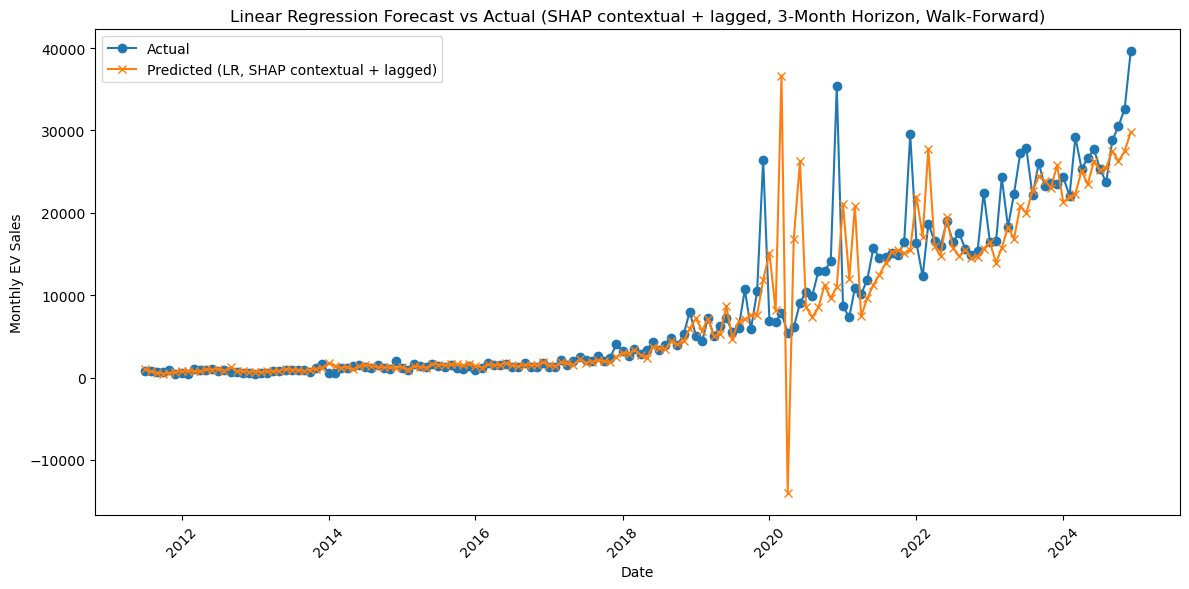

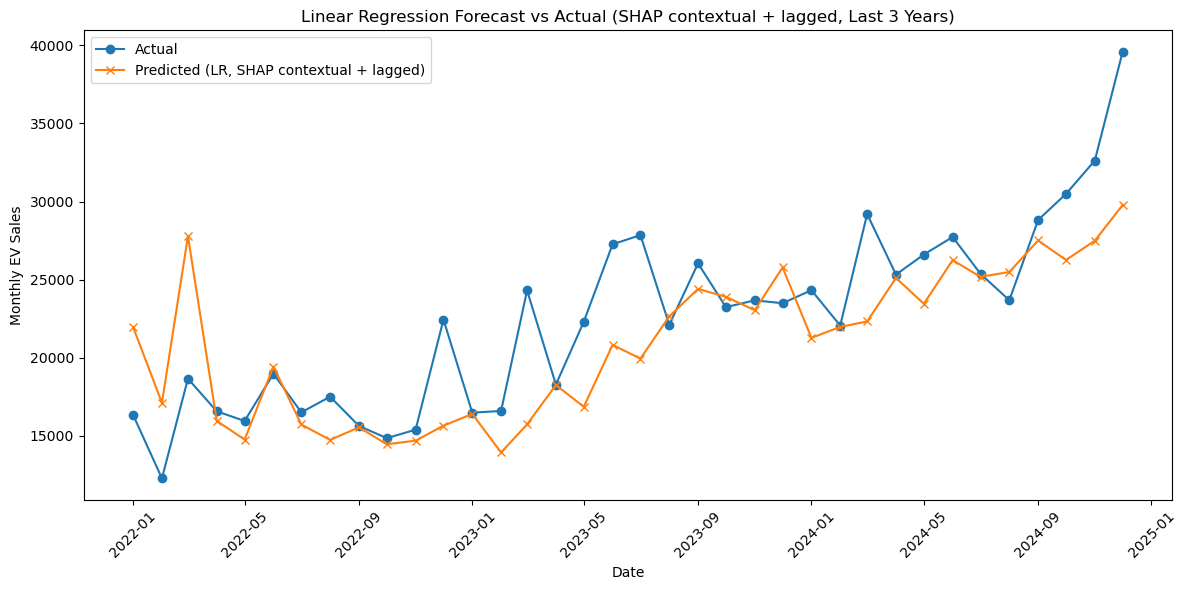

In [53]:
from sklearn.linear_model import LinearRegression

#LR

X = df_lagged[contextual_lagged_features].values
y = df_lagged[target_col].values

predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals))

print("Linear Regression (3-month horizon, SHAP contextual + lagged):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(plot_index, actuals, label='Actual', marker='o')
plt.plot(plot_index, predictions, label='Predicted (LR, SHAP contextual + lagged)', marker='x')
plt.title('Linear Regression Forecast vs Actual (SHAP contextual + lagged, 3-Month Horizon, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom in on last 3 years
plt.figure(figsize=(12, 6))
plt.plot(plot_index[-36:], actuals[-36:], label='Actual', marker='o')
plt.plot(plot_index[-36:], predictions[-36:], label='Predicted (LR, SHAP contextual + lagged)', marker='x')
plt.title('Linear Regression Forecast vs Actual (SHAP contextual + lagged, Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
